# Install and import dependencies

In [1]:
!pip install tensorflow_addons --quiet

     |████████████████████████████████| 1.1 MB 22.1 MB/s 


Load dependencies required

In [2]:
from dataclasses import dataclass
from matplotlib import pyplot
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, precision_recall_fscore_support, r2_score

import os
import os.path
import re
import shutil
import typing
import urllib.request

import keras
import keras.callbacks
import keras.layers
import keras.losses
import keras.optimizers
import keras.regularizers
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tqdm

# Dataset

In [3]:
!cat dependency_treebank/wsj_0001.dp

cat: dependency_treebank/wsj_0001.dp: No such file or directory


## Download the data

- Download the dataset
- Unzip the dataset in the local path

In [4]:
file_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
zip_name = os.path.join(os.getcwd(), "dependency_treebank.zip")
file_name = os.path.join(os.getcwd(), "dependency_treebank")

if not os.path.isdir(file_name):
    if not os.path.isfile(zip_name):
        with urllib.request.urlopen(file_url) as res, open(zip_name, "wb") as f:
            shutil.copyfileobj(res, f)
    shutil.unpack_archive(zip_name, os.getcwd())

## Load the data

- Read the data for training (1-100), validation (101-150) and test (151-199)

In [5]:
class DataLoader:
    #"(" and ")" are tagged with the following character sequences, respectively: "-RRB-" and "-LRB-".
    PUNCTUATIONS = r"(-RRB-)|(-LRB-)|[\.,\\\"'\-\?\:\!;\[\]\(\)\{\}⟨⟩‒–—―‐…\/⁄‘’“”`]+"

    def __init__(self):
        self.prog = re.compile(self.PUNCTUATIONS)

    def __call__(self, start_i: int, end_i: int, desc: typing.Optional[str] = None, remove_punctuation: bool = True):
        df = pd.DataFrame(columns=["text", "tags"])
        # df_y = pd.DataFrame()

        for i in tqdm.trange(start_i, end_i+1, desc=f"Reading {desc} data"):
            idx_len = "0" * (3 - len(str(i)))
            data_file = os.path.join(file_name, f"wsj_0{idx_len}{i}.dp")
            with open(data_file, "r") as f:
                content = [l.strip().split() for l in f.readlines()]
            
            Xrows, yrows = [""], [""]
            i = 0
            for c in content:
                # New line encountered, split the following lines in a new sentence
                if len(c) == 0:
                    i += 1
                    Xrows.append("")
                    yrows.append("")
                    continue
                # Process sentence
                assert len(c) == 3
                
                if remove_punctuation:
                    if self.prog.fullmatch(c[1]) is None:
                      Xrows[i] += (" " if len(Xrows[i]) > 0 else "") + c[0]
                      yrows[i] += (" " if len(yrows[i]) > 0 else "") + c[1]
                else:
                    Xrows[i] += (" " if len(Xrows[i]) > 0 else "") + c[0]
                    yrows[i] += (" " if len(yrows[i]) > 0 else "") + c[1]

            new_df = pd.DataFrame.from_dict({"text": Xrows, "tags": yrows})
            df = pd.concat([df, new_df], axis=0, ignore_index=True)
        return df

data_loader = DataLoader()
df_train = data_loader(1, 100, desc="train", remove_punctuation = False)
df_val = data_loader(101, 150, desc="validation", remove_punctuation = False)
df_test = data_loader(151, 199, desc="test", remove_punctuation = False)

Reading test data: 100%|██████████| 49/49 [00:00<00:00, 804.48it/s]


## Closer look at datasets

In [6]:
df_train.head()

,text,tags
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ..."
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN ."
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN..."
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ..."


##Distribution of the tags

In [7]:
def count_tags_in_df(df: pd.DataFrame) -> dict:
  d_tags = {}
  
  for index in df.index:
    l_tags = df['tags'].iloc[index].split()
    for tag in l_tags:
      d_tags[tag] = d_tags.get(tag, 0) + 1

  return d_tags

In [8]:
ct_train = count_tags_in_df(df_train)
ct_val = count_tags_in_df(df_val)
ct_test = count_tags_in_df(df_test)

all_tags = sorted(list(set([tag for tag in ct_train.keys()] + [tag for tag in ct_val.keys()] + [tag for tag in ct_test.keys()])))

distr_data = {'tags':all_tags, 'train_counts':[ct_train.get(tag, 0) for tag in all_tags], 'val_counts':[ct_val.get(tag, 0) for tag in all_tags], 'test_counts':[ct_test.get(tag, 0) for tag in all_tags]}
distr_df = pd.DataFrame(data = distr_data)
distr_df

,tags,train_counts,val_counts,test_counts
0,#,1,15,0
1,$,342,173,209
2,'',399,225,70
3,",",2571,1528,787
4,-LRB-,52,50,18
5,-RRB-,55,53,18
6,.,1959,1277,638
7,:,293,214,56
8,CC,1141,758,366
9,CD,1439,1249,858


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


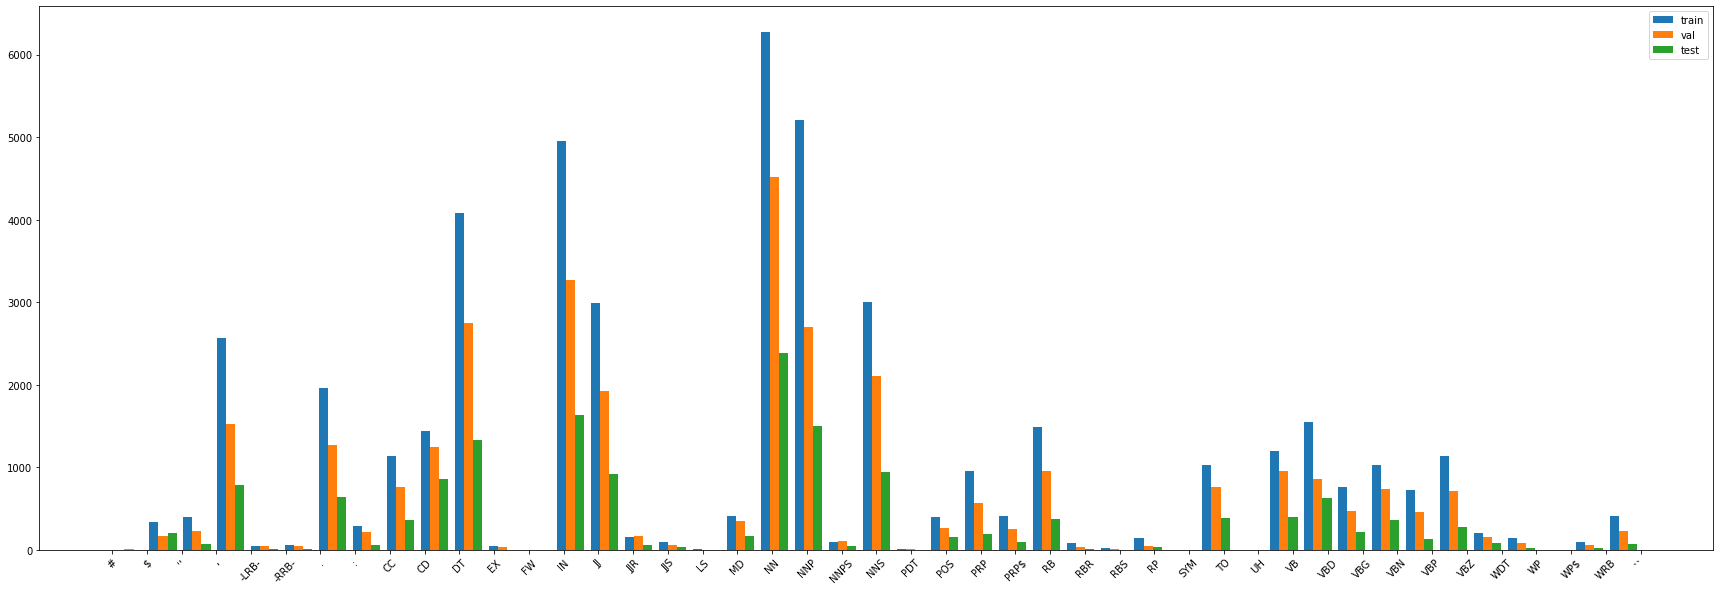

In [9]:
pyplot.figure(figsize=(30,10))
pyplot.xticks(rotation=45)

train_tags = [[tag]*ct_train.get(tag,0) for tag in all_tags]
#flattening
train_tags = [tag for group in train_tags for tag in group]

val_tags = [[tag]*ct_val.get(tag,0) for tag in all_tags]
#flattening
val_tags = [tag for group in val_tags for tag in group]

test_tags = [[tag]*ct_test.get(tag,0) for tag in all_tags]
#flattening
test_tags = [tag for group in test_tags for tag in group]

pyplot.hist([train_tags, val_tags, test_tags], label=['train','val','test'], bins=len(all_tags))
pyplot.legend(loc='upper right')
pyplot.show()

## TODO
- Sentences length
    - Split sentences too long


# Model

In [10]:
@dataclass
class ModelConfiguration:
    EMBEDDING_DIM = 300
    MAX_SEQUENCE = 128
    VOCABULARY_SIZE = 15000

model_conf = ModelConfiguration()

## Dataframe to dataset

In [11]:
def df_to_dataset(df: pd.DataFrame, batch_size: int = 32):
    df = df.copy()
    return tf.data.Dataset.from_tensor_slices((df["text"], df["tags"])).batch(batch_size)

raw_train_ds = df_to_dataset(df_train, 32)
raw_val_ds = df_to_dataset(df_val, 256)
raw_test_ds = df_to_dataset(df_test, 512)
raw_all_ds = df_to_dataset(pd.concat([df_train, df_val, df_test]), 512)

## Tokenization and encoding

### Tokenize features

TODO
- [ ] Tokenization should include also validation and test (for OOV)

In [12]:
class TokenizeFeatures:
    vocab_size: int
    max_sequence: int
    layer: keras.layers.TextVectorization

    def __init__(self, dataset: tf.data.Dataset, vocab_size: int = 10000, max_sequence: int = 64):
        self.vocab_size = vocab_size
        self.max_sequence = max_sequence

        self.layer = keras.layers.TextVectorization(
            max_tokens=self.vocab_size,
            output_mode="int",
            standardize="lower",
            output_sequence_length=self.max_sequence,
        )
        
        features_ds = dataset.map(lambda x, _: x)
        features_ds = features_ds.map(lambda x: tf.strings.split(x, sep=" ").to_tensor())
        features_ds = features_ds.map(lambda x: tf.expand_dims(x, -1))

        self.layer.adapt(features_ds)

    def __call__(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        return dataset.map(lambda x, y: (self.layer(x), y))

    def get_vocabulary(self):
        return self.layer.get_vocabulary()

# tokenize_features = TokenizeFeatures(raw_train_ds, model_conf.VOCABULARY_SIZE, model_conf.MAX_SEQUENCE)
tokenize_features = TokenizeFeatures(raw_all_ds, model_conf.VOCABULARY_SIZE, model_conf.MAX_SEQUENCE)

### Encode of labels

In [13]:
class EncodeLabels:
    max_sequence: int
    layer: keras.layers.StringLookup

    def __init__(self, dataset: tf.data.Dataset, max_sequence: int):
        self.max_sequence = max_sequence
        self.layer = keras.layers.StringLookup(output_mode="int")

        label_ds = dataset.map(lambda _, y: y)
        label_ds = label_ds.map(lambda y: tf.strings.split(y, sep=" ").to_tensor())
        label_ds = label_ds.map(lambda y: y[..., :self.max_sequence])
        label_ds = label_ds.map(lambda y: 
                                tf.concat([
                                    y, 
                                    tf.fill((tf.shape(y)[0], self.max_sequence - tf.shape(y)[-1]), "")], -1))
        
        self.layer.adapt(label_ds)

    def __call__(self, dataset: tf.data.Dataset):
        ds = dataset.map(lambda x, y: (x, tf.strings.split(y, sep=" ").to_tensor()))
        ds = ds.map(lambda x, y: (x, y[..., :self.max_sequence]))
        ds = ds.map(lambda x, y: 
                    (x, tf.concat([
                        y, 
                        tf.fill((tf.shape(y)[0], self.max_sequence - tf.shape(y)[-1]), "")], -1)))
        ds = ds.map(lambda x, y: (x, self.layer(y)))
        return ds

    def get_vocabulary(self):
        return self.layer.get_vocabulary()

    def get_vocabulary_size(self):
        return self.layer.vocabulary_size()

encode_labels = EncodeLabels(raw_all_ds, model_conf.MAX_SEQUENCE)
# encode_labels = EncodeLabels(raw_train_ds, model_conf.MAX_SEQUENCE)

### Decode of labels (use after inference)

In [14]:
class DecodeLabels:
    layer: keras.layers.StringLookup

    def __init__(self, vocabulary):
        self.layer = keras.layers.StringLookup(output_mode="int", vocabulary=vocabulary, invert=True)

    def __call__(self, dataset):
        ds =  tf.math.argmax(dataset, axis=-1)
        ds = self.layer(ds)
        ds =  tf.strings.reduce_join(ds, axis=-1, separator=" ")
        ds = tf.strings.strip(ds)
        return ds

decode_labels = DecodeLabels(encode_labels.get_vocabulary())

### Encode and tokenize datasets

In [15]:
def prepare_data(ds: tf.data.Dataset):
    ds = encode_labels(ds)
    return tokenize_features(ds).prefetch(tf.data.AUTOTUNE)

train_ds = prepare_data(raw_train_ds)    
val_ds = prepare_data(raw_val_ds)  
test_ds = prepare_data(raw_test_ds)

## Embedding layer

In [16]:
!wget -q https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
!unzip -qq glove.840B.300d.zip

### Get GloVe vocabulary

In [17]:
glove_path = f"glove.840B.{model_conf.EMBEDDING_DIM}d.txt"
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in tqdm.tqdm(f):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=" ")
        embeddings_index[word] = coefs

print()
print(f"Found {len(embeddings_index)} word vectors.")

51688it [00:02, 21255.90it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  
2196018it [01:42, 21403.71it/s]


Found 2195885 word vectors.


### Configure pretrained embedding

TODO
- [ ] Create vocabulary for traning, validation and test

In [18]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [19]:
if False:
  vocabulary = tokenize_features.get_vocabulary()
  vocabulary_size = len(vocabulary)

  word_index = dict(zip(vocabulary, range(vocabulary_size)))

  hits = 0
  misses = 0

  set_reproducibility(42)
  rng = np.random.default_rng(seed=42)

  embedding_matrix = np.zeros((vocabulary_size, model_conf.EMBEDDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          # random embedding for missed words
          embedding_matrix[i] = rng.random((model_conf.EMBEDDING_DIM))
          misses += 1
  print(f"Converted {hits} words ({misses} misses)")

## Handling of OOV terms

In [20]:
#We decided to handle OOV terms by generating random embeddings for them.
#Setting reproducibility for random embeddings:
set_reproducibility(42)
rng = np.random.default_rng(seed = 42)

#Glove vocabulary V1
V1 = embeddings_index

#V2 = V1 + OOV1
#We randomly generate the embeddings of the terms out of vocabolary 1 of the training split
#and we add them to V1 to obtain V2
V2 = V1
tokenize_features = TokenizeFeatures(raw_train_ds, model_conf.VOCABULARY_SIZE, model_conf.MAX_SEQUENCE)
for word in tokenize_features.get_vocabulary():
  #If the embedding can be found on V1, we take that.
  #If not, then it's an OOV word and therefore we randomly generate an embedding for it.
  #We check the shape of the word because some embeddings are null.
  if word in V1 and V1[word].shape == (model_conf.EMBEDDING_DIM,):
    V2[word] = V1[word]
  else:
    V2[word] = rng.random((model_conf.EMBEDDING_DIM))

#V3 = V2 + OOV2
V3 = V2
tokenize_features = TokenizeFeatures(raw_val_ds, model_conf.VOCABULARY_SIZE, model_conf.MAX_SEQUENCE)
for word in tokenize_features.get_vocabulary():
  if word in V2 and V2[word].shape == (model_conf.EMBEDDING_DIM,):
    V3[word] = V2[word]
  else:
    V3[word] = rng.random((model_conf.EMBEDDING_DIM))

#V4 = V3 + OOV3
V4 = V3
tokenize_features = TokenizeFeatures(raw_test_ds, model_conf.VOCABULARY_SIZE, model_conf.MAX_SEQUENCE)
for word in tokenize_features.get_vocabulary():
  if word in V3 and V3[word].shape == (model_conf.EMBEDDING_DIM,):
    V4[word] = V3[word]
  else:
    V4[word] = rng.random((model_conf.EMBEDDING_DIM))

## Building the embedding matrix

In [21]:
tokenize_features = TokenizeFeatures(raw_all_ds, model_conf.VOCABULARY_SIZE, model_conf.MAX_SEQUENCE)
vocabulary = tokenize_features.get_vocabulary()
vocabulary_size = len(vocabulary)

word_index = dict(zip(vocabulary, range(vocabulary_size)))

embedding_matrix = np.zeros((vocabulary_size, model_conf.EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_matrix[i] = embeddings_index.get(word)
print(f"Converted {len(word_index.items())} words.")

Converted 10949 words.


## Baseline model

In [22]:
NUM_CLASSES = encode_labels.get_vocabulary_size()
print(f"Number of classes is: {NUM_CLASSES}")

Number of classes is: 47


In [23]:
!mkdir model_checkpoints

## Model With a Bidirectional Long Short-Term Memory (LSTM) Layer

In [24]:
inputs = keras.layers.Input((model_conf.MAX_SEQUENCE, ), dtype="int64")

embedded = keras.layers.Embedding(
    embedding_matrix.shape[0], 
    embedding_matrix.shape[1], 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False)(inputs)

x = keras.layers.SpatialDropout1D(0.3)(embedded)

lstm = keras.layers.LSTM(
    128, 
    return_sequences=True, 
    recurrent_regularizer=keras.regularizers.l2(0.02))
x = keras.layers.Bidirectional(lstm)(x)

x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
BiLSTM_model = keras.Model(inputs, outputs)

opt = tf.optimizers.Adam()
BiLSTM_model.compile(
    optimizer=opt, 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
    
BiLSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          3284700   
                                                                 
 spatial_dropout1d (SpatialD  (None, 128, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128, 256)         439296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 dense (Dense)               (None, 128, 47)           12079 

In [25]:
history_BiLSTM = BiLSTM_model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
62/62 [==============================] - 11s 36ms/step - loss: 2.9553 - accuracy: 0.8329 - val_loss: 1.0618 - val_accuracy: 0.8863
Epoch 2/50
62/62 [==============================] - 1s 21ms/step - loss: 0.6556 - accuracy: 0.8978 - val_loss: 0.4085 - val_accuracy: 0.9094
Epoch 3/50
62/62 [==============================] - 1s 22ms/step - loss: 0.3362 - accuracy: 0.9199 - val_loss: 0.2659 - val_accuracy: 0.9317
Epoch 4/50
62/62 [==============================] - 1s 22ms/step - loss: 0.2430 - accuracy: 0.9380 - val_loss: 0.2027 - val_accuracy: 0.9467
Epoch 5/50
62/62 [==============================] - 1s 23ms/step - loss: 0.1953 - accuracy: 0.9494 - val_loss: 0.1636 - val_accuracy: 0.9575
Epoch 6/50
62/62 [==============================] - 1s 21ms/step - loss: 0.1636 - accuracy: 0.9574 - val_loss: 0.1373 - val_accuracy: 0.9642
Epoch 7/50
62/62 [==============================] - 1s 22ms/step - loss: 0.1429 - accuracy: 0.9623 - val_loss: 0.1190 - val_accuracy: 0.9695
Epoch 8/50
6

## Experiments:

## Model with a Gated Recurrent Units (GRU) Layer

In [26]:
inputs = keras.layers.Input((model_conf.MAX_SEQUENCE, ), dtype="int64")

embedded = keras.layers.Embedding(
    embedding_matrix.shape[0], 
    embedding_matrix.shape[1], 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False)(inputs)

x = keras.layers.SpatialDropout1D(0.3)(embedded)

gru = keras.layers.GRU(
    128, 
    return_sequences=True, 
    recurrent_regularizer=keras.regularizers.l2(0.02))
x = keras.layers.Bidirectional(gru)(x)

x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
GRU_model = keras.Model(inputs, outputs)

opt = tf.optimizers.Adam()
GRU_model.compile(
    optimizer=opt, 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
    
GRU_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 300)          3284700   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 128, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 256)         330240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 dense_1 (Dense)             (None, 128, 47)           1207

In [27]:
history_GRU = GRU_model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
62/62 [==============================] - 5s 31ms/step - loss: 3.1217 - accuracy: 0.8486 - val_loss: 1.2202 - val_accuracy: 0.9029
Epoch 2/50
62/62 [==============================] - 1s 18ms/step - loss: 0.7150 - accuracy: 0.9172 - val_loss: 0.3908 - val_accuracy: 0.9360
Epoch 3/50
62/62 [==============================] - 1s 18ms/step - loss: 0.2968 - accuracy: 0.9405 - val_loss: 0.2125 - val_accuracy: 0.9506
Epoch 4/50
62/62 [==============================] - 1s 18ms/step - loss: 0.1930 - accuracy: 0.9531 - val_loss: 0.1560 - val_accuracy: 0.9606
Epoch 5/50
62/62 [==============================] - 1s 18ms/step - loss: 0.1545 - accuracy: 0.9603 - val_loss: 0.1288 - val_accuracy: 0.9669
Epoch 6/50
62/62 [==============================] - 1s 18ms/step - loss: 0.1329 - accuracy: 0.9650 - val_loss: 0.1121 - val_accuracy: 0.9707
Epoch 7/50
62/62 [==============================] - 1s 18ms/step - loss: 0.1194 - accuracy: 0.9678 - val_loss: 0.1001 - val_accuracy: 0.9731
Epoch 8/50
62

## Model with two Bidirectional Long Short-Term Memory (LSTM) Layers

In [28]:
inputs = keras.layers.Input((model_conf.MAX_SEQUENCE, ), dtype="int64")

embedded = keras.layers.Embedding(
    embedding_matrix.shape[0], 
    embedding_matrix.shape[1], 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False)(inputs)

x = keras.layers.SpatialDropout1D(0.3)(embedded)

lstm = keras.layers.LSTM(
    128, 
    return_sequences=True, 
    recurrent_regularizer=keras.regularizers.l2(0.02))
x = keras.layers.Bidirectional(lstm)(x)

lstm = keras.layers.LSTM(
    128, 
    return_sequences=True, 
    recurrent_regularizer=keras.regularizers.l2(0.02))
x = keras.layers.Bidirectional(lstm)(x)

x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
BiLSTM2_model = keras.Model(inputs, outputs)

opt = tf.optimizers.Adam()
BiLSTM2_model.compile(
    optimizer=opt, 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
    
BiLSTM2_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 300)          3284700   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 128, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128, 256)         439296    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128, 256)         394240    
 nal)                                                            
                                                           

In [29]:
history_BiLSTM2 = BiLSTM2_model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
62/62 [==============================] - 9s 60ms/step - loss: 5.0701 - accuracy: 0.8226 - val_loss: 1.6489 - val_accuracy: 0.8583
Epoch 2/50
62/62 [==============================] - 2s 38ms/step - loss: 0.9418 - accuracy: 0.8687 - val_loss: 0.5373 - val_accuracy: 0.8909
Epoch 3/50
62/62 [==============================] - 2s 38ms/step - loss: 0.4106 - accuracy: 0.9043 - val_loss: 0.3036 - val_accuracy: 0.9204
Epoch 4/50
62/62 [==============================] - 2s 38ms/step - loss: 0.2606 - accuracy: 0.9303 - val_loss: 0.2070 - val_accuracy: 0.9424
Epoch 5/50
62/62 [==============================] - 2s 37ms/step - loss: 0.1906 - accuracy: 0.9480 - val_loss: 0.1539 - val_accuracy: 0.9587
Epoch 6/50
62/62 [==============================] - 2s 38ms/step - loss: 0.1504 - accuracy: 0.9594 - val_loss: 0.1217 - val_accuracy: 0.9685
Epoch 7/50
62/62 [==============================] - 2s 37ms/step - loss: 0.1268 - accuracy: 0.9656 - val_loss: 0.1026 - val_accuracy: 0.9724
Epoch 8/50
62

## Model with an additional Dense Layer

In [30]:
inputs = keras.layers.Input((model_conf.MAX_SEQUENCE, ), dtype="int64")

embedded = keras.layers.Embedding(
    embedding_matrix.shape[0], 
    embedding_matrix.shape[1], 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False)(inputs)

x = keras.layers.SpatialDropout1D(0.3)(embedded)

lstm = keras.layers.LSTM(
    128, 
    return_sequences=True, 
    recurrent_regularizer=keras.regularizers.l2(0.02))
x = keras.layers.Bidirectional(lstm)(x)

x = keras.layers.Dropout(0.2)(x)

x = keras.layers.TimeDistributed(keras.layers.Dense(NUM_CLASSES, activation="relu"))(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)



BiLSTM_2dense_model = keras.Model(inputs, outputs)

opt = tf.optimizers.Adam()
BiLSTM_2dense_model.compile(
    optimizer=opt, 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
    
BiLSTM_2dense_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 128, 300)          3284700   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 128, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_4 (Bidirectio  (None, 128, 256)         439296    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                                 
 time_distributed (TimeDistr  (None, 128, 47)          1207

In [31]:
history_BiLSTM_2dense = BiLSTM_2dense_model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
62/62 [==============================] - 5s 35ms/step - loss: 3.0840 - accuracy: 0.8146 - val_loss: 1.0600 - val_accuracy: 0.8697
Epoch 2/50
62/62 [==============================] - 1s 22ms/step - loss: 0.6600 - accuracy: 0.8869 - val_loss: 0.4146 - val_accuracy: 0.9043
Epoch 3/50
62/62 [==============================] - 1s 22ms/step - loss: 0.3404 - accuracy: 0.9141 - val_loss: 0.2651 - val_accuracy: 0.9298
Epoch 4/50
62/62 [==============================] - 1s 22ms/step - loss: 0.2405 - accuracy: 0.9358 - val_loss: 0.1932 - val_accuracy: 0.9480
Epoch 5/50
62/62 [==============================] - 1s 22ms/step - loss: 0.1872 - accuracy: 0.9488 - val_loss: 0.1521 - val_accuracy: 0.9587
Epoch 6/50
62/62 [==============================] - 1s 22ms/step - loss: 0.1546 - accuracy: 0.9573 - val_loss: 0.1253 - val_accuracy: 0.9655
Epoch 7/50
62/62 [==============================] - 1s 23ms/step - loss: 0.1348 - accuracy: 0.9624 - val_loss: 0.1079 - val_accuracy: 0.9708
Epoch 8/50
62

In [32]:
if False:
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE, ), dtype="int64")

    embedded = keras.layers.Embedding(
        embedding_matrix.shape[0], 
        embedding_matrix.shape[1], 
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False)(inputs)

    x = keras.layers.SpatialDropout1D(0.3)(embedded)

    lstm = keras.layers.GRU(
        128, 
        return_sequences=True, 
        recurrent_regularizer=keras.regularizers.l2(0.02))
    x = keras.layers.Bidirectional(lstm)(x)

    # lstm = keras.layers.LSTM(
    #     128, 
    #     return_sequences=True, 
    #     recurrent_regularizer=keras.regularizers.l2(0.02))
    # x = keras.layers.Bidirectional(lstm)(x)

    x = keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    opt = tf.optimizers.Adam()
    model.compile(
        optimizer=opt, 
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"])

    model.summary()

## Training

In [33]:
if False:
    model_checkpoint = keras.callbacks.ModelCheckpoint("./model_checkpoints", monitor="val_accuracy", save_best_only=True)
    # early_stopping = EarlyStopping(monitor="val_loss", patience=5)
    # reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.3)

    history = model.fit(train_ds, validation_data=val_ds, epochs=20)
    # history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[model_checkpoint])

## Inference

- [ ] Compute F1-macro score

## Metrics and error analysis

## Checking whether the results on the test set are coherent with the results on the validation set.

In [34]:
#Test set
yPreds_BiLSTM = BiLSTM_model.predict(test_ds)
yPreds_GRU = GRU_model.predict(test_ds)
yPreds_BiLSTM2 = BiLSTM2_model.predict(test_ds)
yPreds_BiLSTM_2dense = BiLSTM_2dense_model.predict(test_ds)

#Validation set
yPreds_BiLSTM_val = BiLSTM_model.predict(val_ds)
yPreds_GRU_val = GRU_model.predict(val_ds)
yPreds_BiLSTM2_val = BiLSTM2_model.predict(val_ds)
yPreds_BiLSTM_2dense_val = BiLSTM_2dense_model.predict(val_ds)

6/6 [==============================] - 0s 18ms/step


In [35]:
def prepare_pred(yPreds: tf.data.Dataset, stringLookupLayer: keras.layers.StringLookup) -> np.ndarray:
    #I define the arrays containing true values and predictions:
    pred = tf.math.argmax(yPreds, axis = -1)
    pred = stringLookupLayer(pred)
    pred = tf.strings.strip(pred)
    pred = pred.numpy().reshape(-1)
    pred = pred.astype(str)
    return pred

In [36]:
#Predictions
#Test set
predBiLSTM = prepare_pred(yPreds_BiLSTM, decode_labels.layer)
predGRU = prepare_pred(yPreds_GRU, decode_labels.layer)
predBiLSTM2 = prepare_pred(yPreds_BiLSTM2, decode_labels.layer)
predBiLSTM_2dense = prepare_pred(yPreds_BiLSTM_2dense, decode_labels.layer)

#Validation set
predBiLSTM_val = prepare_pred(yPreds_BiLSTM_val, decode_labels.layer)
predGRU_val = prepare_pred(yPreds_GRU_val, decode_labels.layer)
predBiLSTM2_val = prepare_pred(yPreds_BiLSTM2_val, decode_labels.layer)
predBiLSTM_2dense_val = prepare_pred(yPreds_BiLSTM_2dense_val, decode_labels.layer)

#True values
#Test set
true = tf.strings.strip(decode_labels.layer(next(iter(prepare_data(df_to_dataset(df_test, len(df_test)))))[1])).numpy().reshape(-1).astype(str)
#Now we remove punctuation. We do so by determining where the punctuation is from the true values and by removing the elements at the same positions from all the arrays.
#We want to use a regex to detect tags referring to punctuation. I temporarily go through Pandas.
true_df = pd.Series(true)
mask = ~true_df.str.fullmatch(DataLoader.PUNCTUATIONS)
np_mask = mask.to_numpy()

#Validation set
true_val = tf.strings.strip(decode_labels.layer(next(iter(prepare_data(df_to_dataset(df_val, len(df_val)))))[1])).numpy().reshape(-1).astype(str)
true_val_df = pd.Series(true_val)
mask_val = ~true_val_df.str.fullmatch(DataLoader.PUNCTUATIONS)
np_mask_val = mask_val.to_numpy()


#Finally we consider only the tags we're interested in:
#Test set
predBiLSTM_no_punct = predBiLSTM[np_mask]
predGRU_no_punct = predGRU[np_mask]
predBiLSTM2_no_punct = predBiLSTM2[np_mask]
predBiLSTM_2dense_no_punct = predBiLSTM_2dense[np_mask]

#Validation set
predBiLSTM_no_punct_val = predBiLSTM_val[np_mask_val]
predGRU_no_punct_val = predGRU_val[np_mask_val]
predBiLSTM2_no_punct_val = predBiLSTM2_val[np_mask_val]
predBiLSTM_2dense_no_punct_val = predBiLSTM_2dense_val[np_mask_val]

#Test set
true_no_punct = true[np_mask]
#Validation set
true_no_punct_val = true_val[np_mask_val]

In [37]:
#We compute and display the classification report, as requested.
print('Classification report for the model with a Bidirectional LSTM Layer (test)')
print(classification_report(true_no_punct,predBiLSTM_no_punct,zero_division=0))
crep_BiLSTM_dict = classification_report(true_no_punct,predBiLSTM_no_punct,zero_division=0, output_dict = True)
print(75*'-')
print('Classification report for the model with a Bidirectional LSTM Layer (val)')
print(classification_report(true_no_punct_val,predBiLSTM_no_punct_val,zero_division=0))
crep_BiLSTM_val_dict = classification_report(true_no_punct_val,predBiLSTM_no_punct_val,zero_division=0, output_dict = True)
print(75*'=')

print('Classification report for the model with a GRU Layer (test)')
print(classification_report(true_no_punct,predGRU_no_punct,zero_division=0))
crep_GRU_dict = classification_report(true_no_punct,predGRU_no_punct,zero_division=0, output_dict = True)
print(75*'-')
print('Classification report for the model with a GRU Layer (val)')
print(classification_report(true_no_punct_val,predGRU_no_punct_val,zero_division=0))
crep_GRU_val_dict = classification_report(true_no_punct_val,predGRU_no_punct_val,zero_division=0, output_dict = True)
print(75*'=')

print('Classification report for the model with two Bidirectional LSTM Layers (test)')
print(classification_report(true_no_punct,predBiLSTM2_no_punct,zero_division=0))
crep_BiLSTM2_dict = classification_report(true_no_punct,predBiLSTM2_no_punct,zero_division=0, output_dict = True)
print(75*'-')
print('Classification report for the model with two Bidirectional LSTM Layers (val)')
print(classification_report(true_no_punct_val,predBiLSTM2_no_punct_val,zero_division=0))
crep_BiLSTM2_val_dict = classification_report(true_no_punct_val,predBiLSTM2_no_punct_val,zero_division=0, output_dict = True)
print(75*'=')

print('Classification report for the model with two Dense Layers (test)')
print(classification_report(true_no_punct,predBiLSTM_2dense_no_punct,zero_division=0))
crep_BiLSTM_2dense_dict = classification_report(true_no_punct,predBiLSTM_2dense_no_punct,zero_division=0, output_dict = True)
print(75*'-')
print('Classification report for the model with two Dense Layers (val)')
print(classification_report(true_no_punct_val,predBiLSTM_2dense_no_punct_val,zero_division=0))
crep_BiLSTM_2dense_val_dict = classification_report(true_no_punct_val,predBiLSTM_2dense_no_punct_val,zero_division=0, output_dict = True)
print(75*'=')

Classification report for the model with a Bidirectional LSTM Layer (test)
              precision    recall  f1-score   support

                   1.00      1.00      1.00     67911
           $       1.00      1.00      1.00       209
          CC       1.00      1.00      1.00       366
          CD       0.99      0.97      0.98       858
          DT       0.99      0.99      0.99      1335
          EX       0.83      1.00      0.91         5
          IN       0.98      0.97      0.97      1630
          JJ       0.84      0.85      0.84       918
         JJR       0.79      0.90      0.84        59
         JJS       0.88      0.97      0.92        31
          MD       0.96      1.00      0.98       167
          NN       0.91      0.93      0.92      2383
         NNP       0.91      0.90      0.91      1504
        NNPS       0.67      0.05      0.09        44
         NNS       0.92      0.96      0.94       941
         PDT       0.00      0.00      0.00         4
      

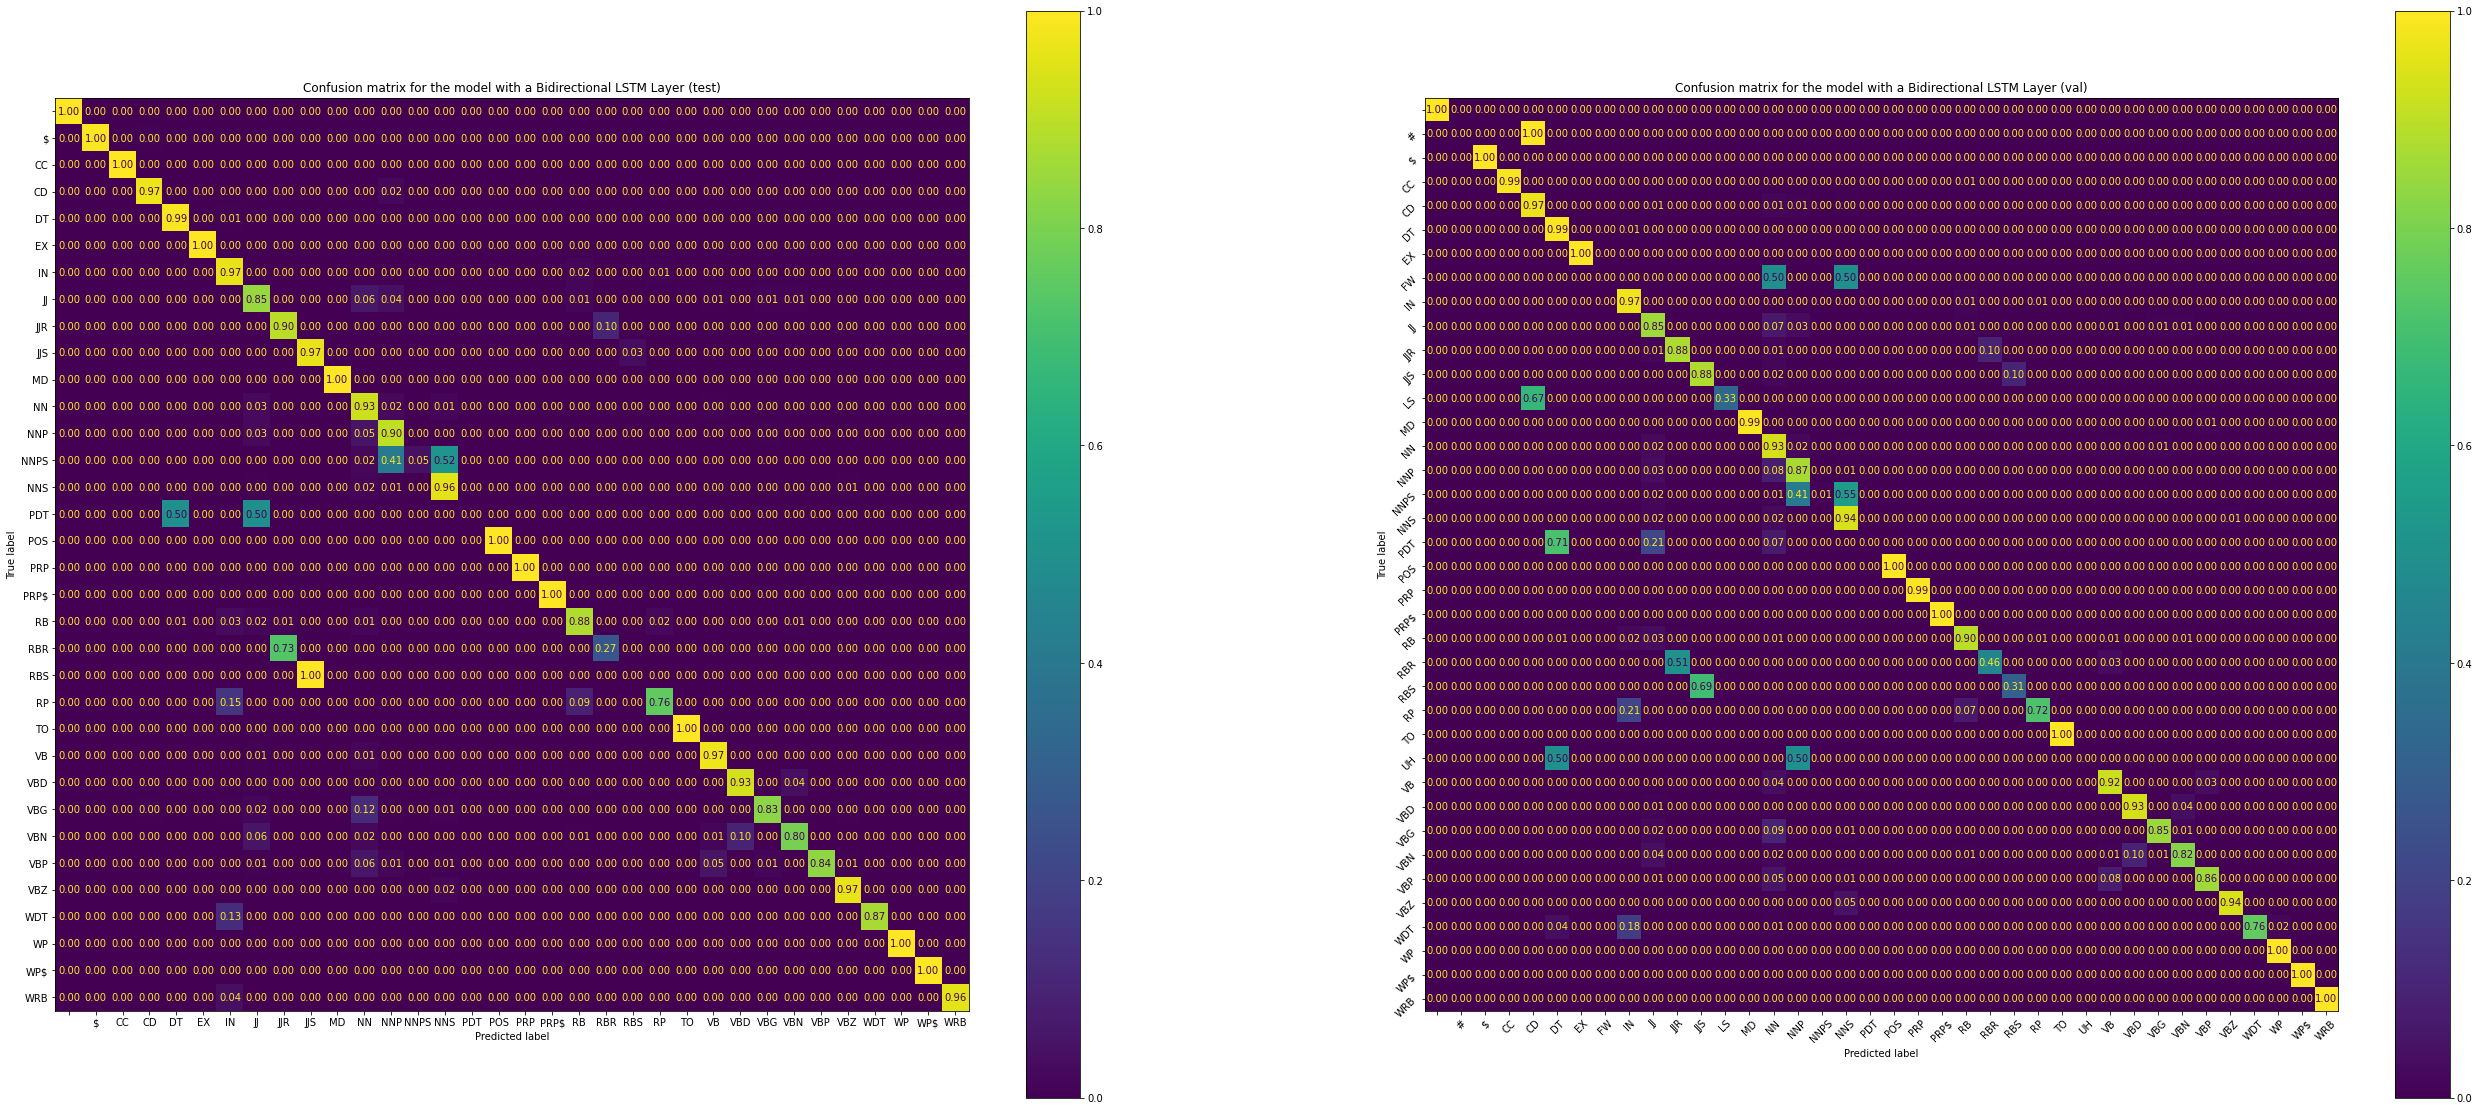

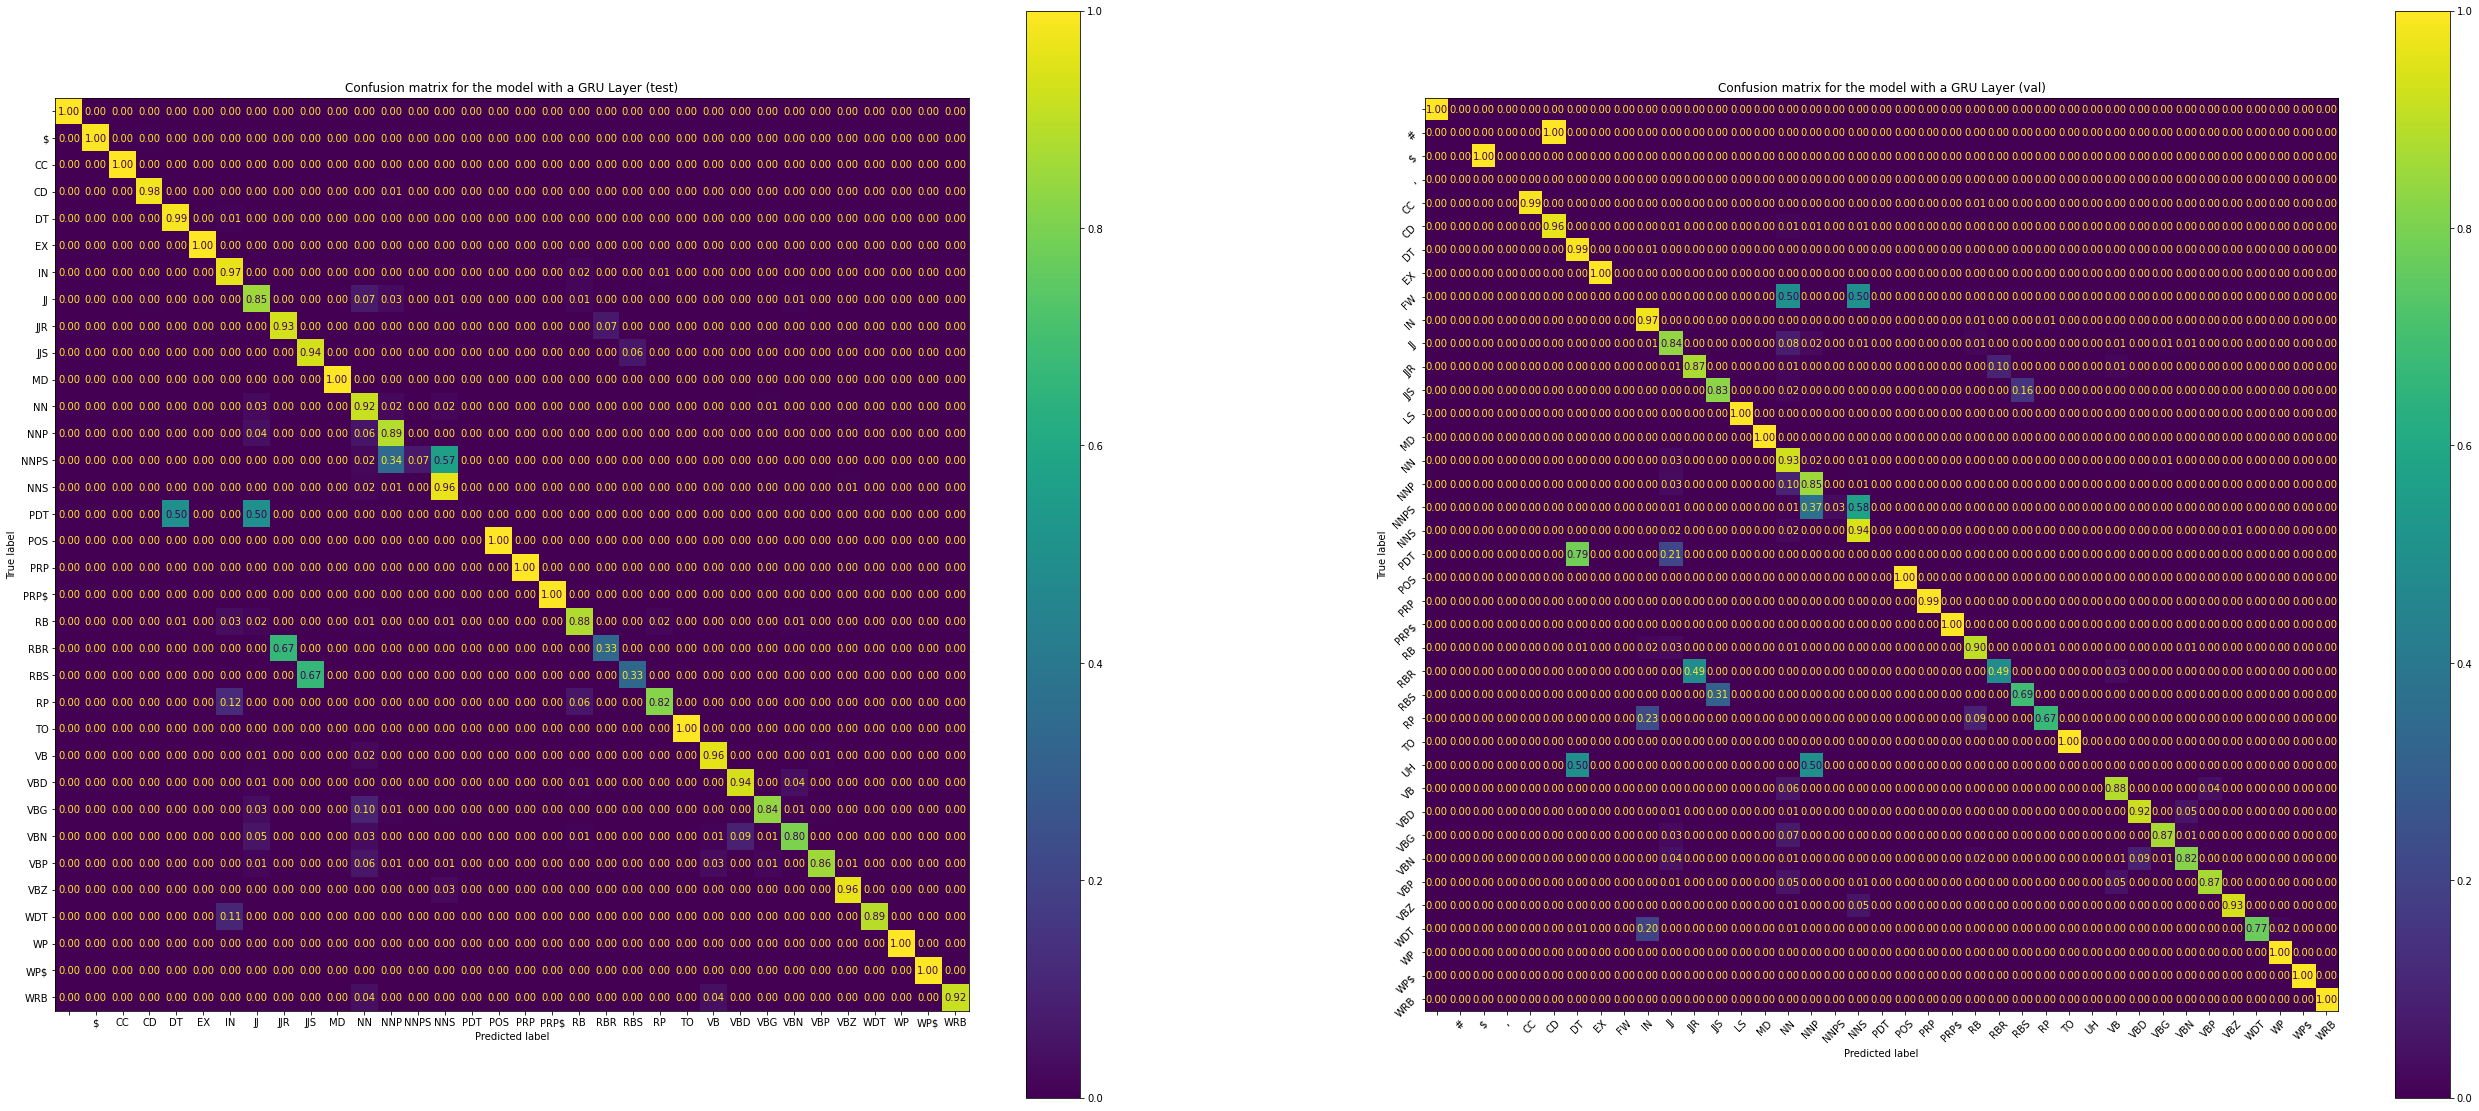

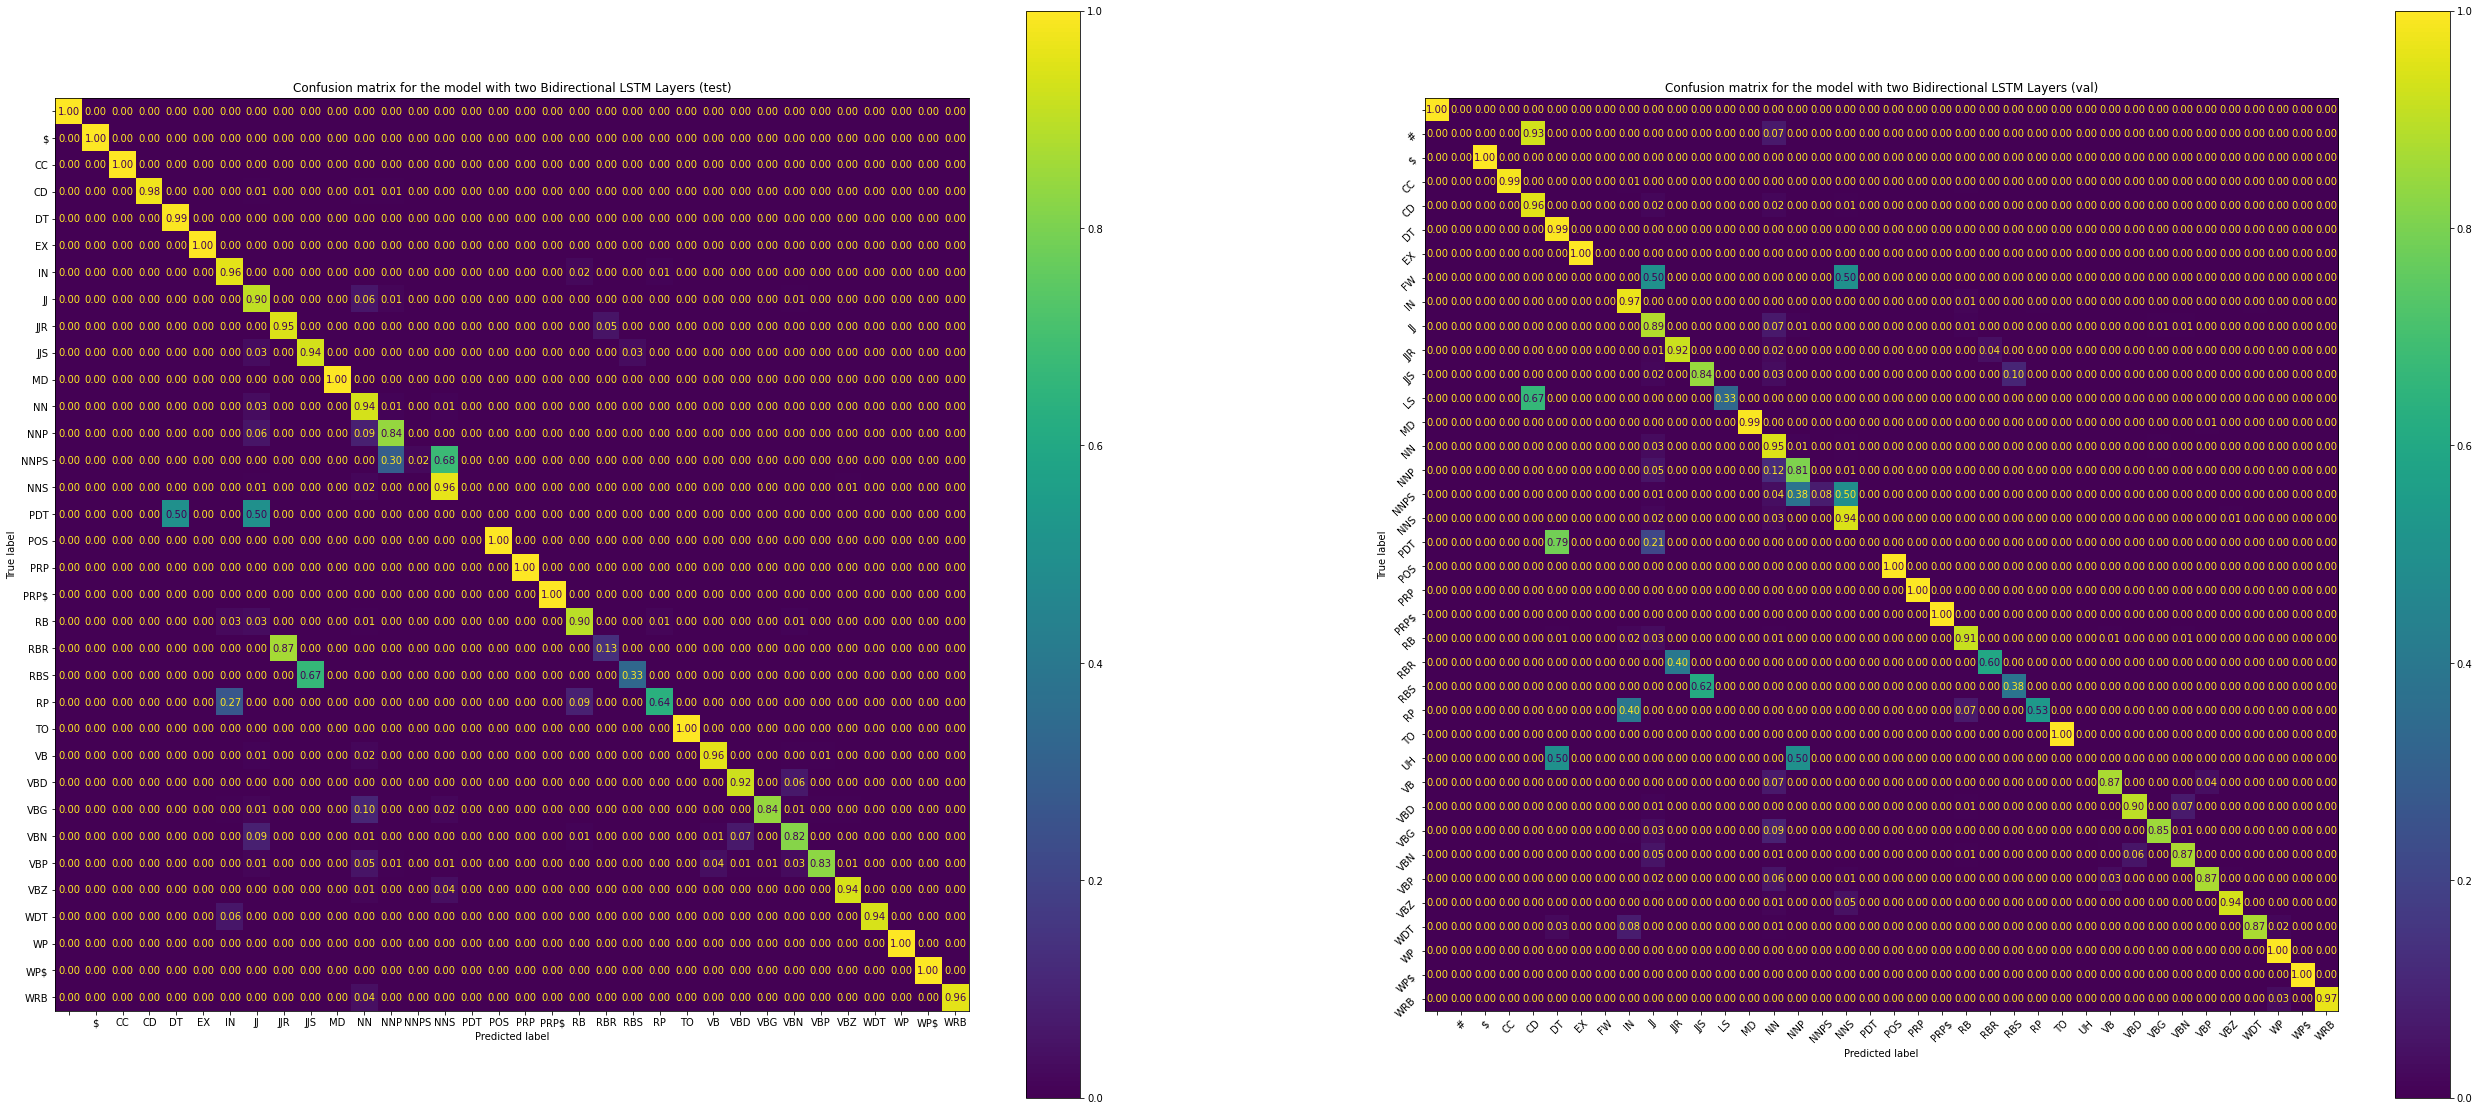

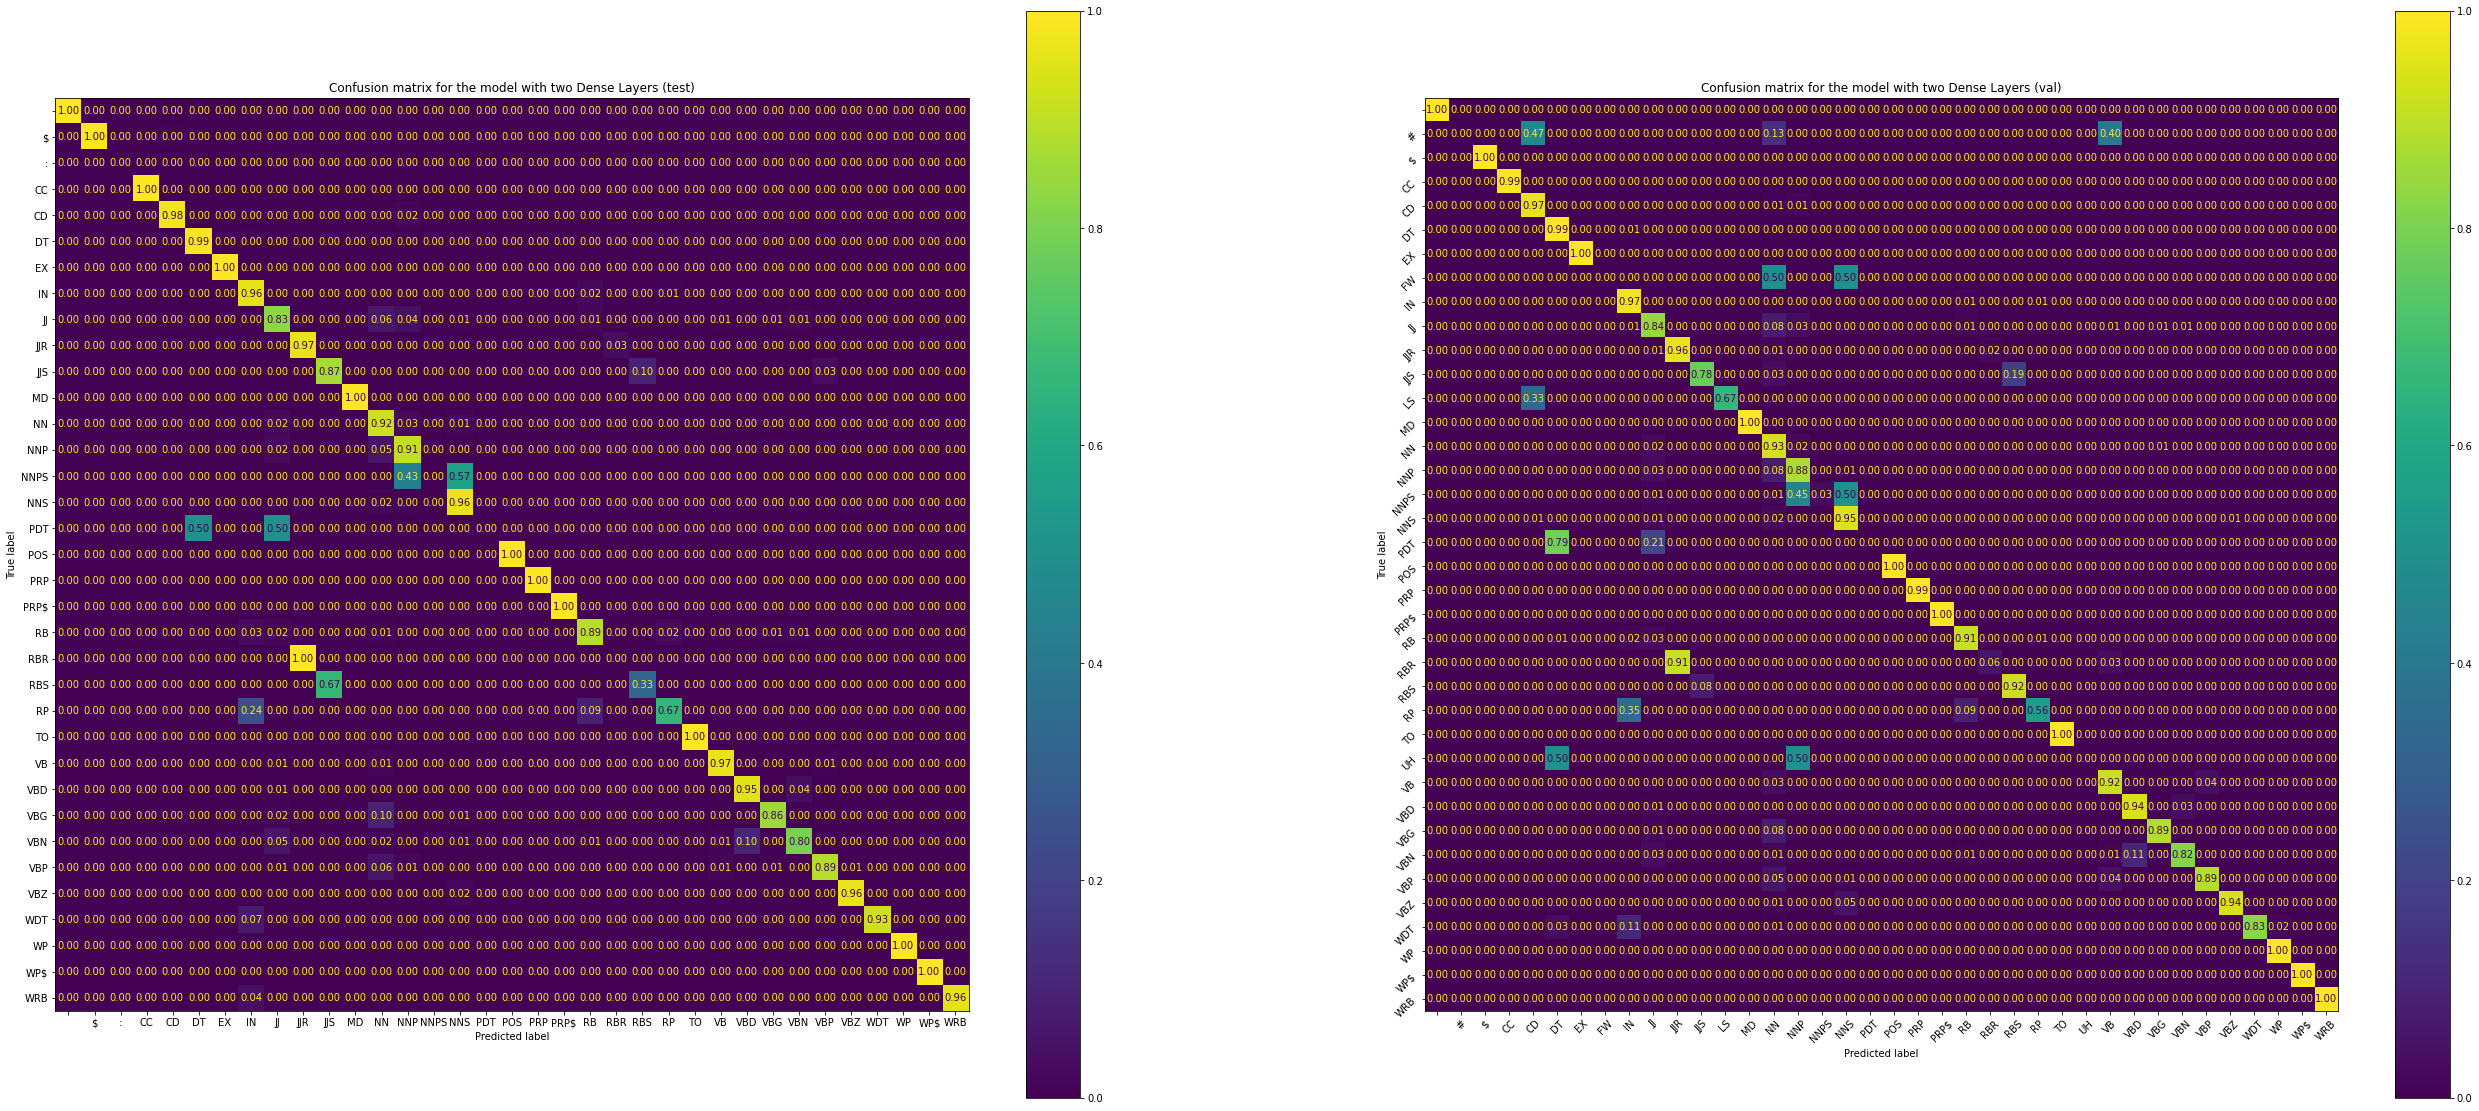

In [38]:
#Confusion matrices:
#Test set
disp = ConfusionMatrixDisplay(confusion_matrix(true_no_punct, predBiLSTM_no_punct, normalize='true'), display_labels=np.unique(np.concatenate([predBiLSTM_no_punct, true_no_punct])))
_, axs = pyplot.subplots(1,2,figsize=(45,20))
axs[0].set_title('Confusion matrix for the model with a Bidirectional LSTM Layer (test)')
disp.plot(ax = axs[0], values_format='.2f')
pyplot.xticks(rotation=45)
pyplot.yticks(rotation=45)

#Validation set
disp = ConfusionMatrixDisplay(confusion_matrix(true_no_punct_val, predBiLSTM_no_punct_val, normalize='true'), display_labels=np.unique(np.concatenate([predBiLSTM_no_punct_val, true_no_punct_val])))
axs[1].set_title('Confusion matrix for the model with a Bidirectional LSTM Layer (val)')
disp.plot(ax = axs[1], values_format='.2f')
pyplot.xticks(rotation=45)
pyplot.yticks(rotation=45)
pyplot.show()


#Test set
disp = ConfusionMatrixDisplay(confusion_matrix(true_no_punct, predGRU_no_punct, normalize='true'), display_labels=np.unique(np.concatenate([predGRU_no_punct, true_no_punct])))
_, axs = pyplot.subplots(1,2,figsize=(45,20))
axs[0].set_title('Confusion matrix for the model with a GRU Layer (test)')
disp.plot(ax = axs[0], values_format='.2f')
pyplot.xticks(rotation=45)
pyplot.yticks(rotation=45)

#Validation set
disp = ConfusionMatrixDisplay(confusion_matrix(true_no_punct_val, predGRU_no_punct_val, normalize='true'), display_labels=np.unique(np.concatenate([predGRU_no_punct_val, true_no_punct_val])))
axs[1].set_title('Confusion matrix for the model with a GRU Layer (val)')
disp.plot(ax = axs[1], values_format='.2f')
pyplot.xticks(rotation=45)
pyplot.yticks(rotation=45)
pyplot.show()


#Test set
disp = ConfusionMatrixDisplay(confusion_matrix(true_no_punct, predBiLSTM2_no_punct, normalize='true'), display_labels=np.unique(np.concatenate([predBiLSTM2_no_punct, true_no_punct])))
_, axs = pyplot.subplots(1,2,figsize=(45,20))
axs[0].set_title('Confusion matrix for the model with two Bidirectional LSTM Layers (test)')
disp.plot(ax = axs[0], values_format='.2f')
pyplot.xticks(rotation=45)
pyplot.yticks(rotation=45)

#Validation set
disp = ConfusionMatrixDisplay(confusion_matrix(true_no_punct_val, predBiLSTM2_no_punct_val, normalize='true'), display_labels=np.unique(np.concatenate([predBiLSTM2_no_punct_val, true_no_punct_val])))
axs[1].set_title('Confusion matrix for the model with two Bidirectional LSTM Layers (val)')
disp.plot(ax = axs[1], values_format='.2f')
pyplot.xticks(rotation=45)
pyplot.yticks(rotation=45)
pyplot.show()


#Test set
disp = ConfusionMatrixDisplay(confusion_matrix(true_no_punct, predBiLSTM_2dense_no_punct, normalize='true'), display_labels=np.unique(np.concatenate([predBiLSTM_2dense_no_punct, true_no_punct])))
_, axs = pyplot.subplots(1,2,figsize=(45,20))
axs[0].set_title('Confusion matrix for the model with two Dense Layers (test)')
disp.plot(ax = axs[0], values_format='.2f')
pyplot.xticks(rotation=45)
pyplot.yticks(rotation=45)

#Validation set
disp = ConfusionMatrixDisplay(confusion_matrix(true_no_punct_val, predBiLSTM_2dense_no_punct_val, normalize='true'), display_labels=np.unique(np.concatenate([predBiLSTM_2dense_no_punct_val, true_no_punct_val])))
axs[1].set_title('Confusion matrix for the model with two Dense Layers (val)')
disp.plot(ax = axs[1], values_format='.2f')
pyplot.xticks(rotation=45)
pyplot.yticks(rotation=45)
pyplot.show()

### R2, Mean Average Error, Mean Square Error

In [39]:
#I need to convert from string representations to numbers. #I do so by using the vocabulary adapted to the dataset.
def map_array_from_to(from_values, to_values, array):
    sort_idx = np.argsort(from_values)
    idx = np.searchsorted(from_values, array, sorter = sort_idx)
    out = to_values[sort_idx][idx]
    return out

def print_metrics(title, r2, mae, mse, bold_footer=False):
    
    hspace = 20
    
    r2 = '{:e}'.format(r2)
    mae = '{:e}'.format(mae)
    mse = '{:e}'.format(mse)
    
    print(title)
    header = 'R2'.rjust(hspace) + ' ' + 'MAE'.rjust(hspace) + ' ' + 'MSE'.rjust(hspace)
    print(header)
    print(r2.rjust(hspace), mae.rjust(hspace), mse.rjust(hspace))
    print(len(header)*('-' if not bold_footer else '='))

In [40]:
voc, voc_idx = np.array(encode_labels.get_vocabulary()), np.arange(0, len(encode_labels.get_vocabulary()))

#Convert string representations of the tags to the respective numbers
#Test set
true_no_punct_idx = map_array_from_to(voc, voc_idx, true_no_punct)
predBiLSTM_no_punct_idx = map_array_from_to(voc, voc_idx, predBiLSTM_no_punct)
predGRU_no_punct_idx = map_array_from_to(voc, voc_idx, predGRU_no_punct)
predBiLSTM2_no_punct_idx = map_array_from_to(voc, voc_idx, predBiLSTM2_no_punct)
predBiLSTM_2dense_no_punct_idx = map_array_from_to(voc, voc_idx, predBiLSTM_2dense_no_punct)
#Validation set
true_no_punct_val_idx = map_array_from_to(voc, voc_idx, true_no_punct_val)
predBiLSTM_no_punct_val_idx = map_array_from_to(voc, voc_idx, predBiLSTM_no_punct_val)
predGRU_no_punct_val_idx = map_array_from_to(voc, voc_idx, predGRU_no_punct_val)
predBiLSTM2_no_punct_val_idx = map_array_from_to(voc, voc_idx, predBiLSTM2_no_punct_val)
predBiLSTM_2dense_no_punct_val_idx = map_array_from_to(voc, voc_idx, predBiLSTM_2dense_no_punct_val)

#Calculation of r2, mae e mse of the values we're interested in.

#bilstm
#Test set
r2_bilstm = r2_score(true_no_punct_idx, predBiLSTM_no_punct_idx)
mae_bilstm = mean_absolute_error(true_no_punct_idx, predBiLSTM_no_punct_idx)
mse_bilstm = mean_squared_error(true_no_punct_idx, predBiLSTM_no_punct_idx)
print_metrics('Scores for the model with a Bidirectional LSTM Layer (test)', r2_bilstm, mae_bilstm, mse_bilstm)
#Validation set
r2_bilstm_val = r2_score(true_no_punct_val_idx, predBiLSTM_no_punct_val_idx)
mae_bilstm_val = mean_absolute_error(true_no_punct_val_idx, predBiLSTM_no_punct_val_idx)
mse_bilstm_val = mean_squared_error(true_no_punct_val_idx, predBiLSTM_no_punct_val_idx)
print_metrics('Scores for the model with a Bidirectional LSTM Layer (val)', r2_bilstm_val, mae_bilstm_val, mse_bilstm_val, True)
#gru
#Test set
r2_gru = r2_score(true_no_punct_idx, predGRU_no_punct_idx)
mae_gru = mean_absolute_error(true_no_punct_idx, predGRU_no_punct_idx)
mse_gru = mean_squared_error(true_no_punct_idx, predGRU_no_punct_idx)
print_metrics('Scores for the model with a GRU Layer (test)', r2_gru, mae_gru, mse_gru)
#Validation set
r2_gru_val = r2_score(true_no_punct_val_idx, predGRU_no_punct_val_idx)
mae_gru_val = mean_absolute_error(true_no_punct_val_idx, predGRU_no_punct_val_idx)
mse_gru_val = mean_squared_error(true_no_punct_val_idx, predGRU_no_punct_val_idx)
print_metrics('Scores for the model with a GRU Layer (val)', r2_gru_val, mae_gru_val, mse_gru_val, True)
#2bilstm
#Test set
r2_2bilstm = r2_score(true_no_punct_idx, predBiLSTM2_no_punct_idx)
mae_2bilstm = mean_absolute_error(true_no_punct_idx, predBiLSTM2_no_punct_idx)
mse_2bilstm = mean_squared_error(true_no_punct_idx, predBiLSTM2_no_punct_idx)
print_metrics('Scores for the model with two Bidirectional LSTM Layers (test)', r2_2bilstm, mae_2bilstm, mse_2bilstm)
#Validation set
r2_2bilstm_val = r2_score(true_no_punct_val_idx, predBiLSTM2_no_punct_val_idx)
mae_2bilstm_val = mean_absolute_error(true_no_punct_val_idx, predBiLSTM2_no_punct_val_idx)
mse_2bilstm_val = mean_squared_error(true_no_punct_val_idx, predBiLSTM2_no_punct_val_idx)
print_metrics('Scores for the model with two Bidirectional LSTM Layers (val)', r2_2bilstm_val, mae_2bilstm_val, mse_2bilstm_val, True)
#bilstm_2dense
#Test set
r2_bilstm_2dense = r2_score(true_no_punct_idx, predBiLSTM_2dense_no_punct_idx)
mae_bilstm_2dense = mean_absolute_error(true_no_punct_idx, predBiLSTM_2dense_no_punct_idx)
mse_bilstm_2dense = mean_squared_error(true_no_punct_idx, predBiLSTM_2dense_no_punct_idx)
print_metrics('Scores for the model with two Dense Layers (test)', r2_bilstm_2dense, mae_bilstm_2dense, mse_bilstm_2dense)
#Validation set
r2_bilstm_2dense_val = r2_score(true_no_punct_val_idx, predBiLSTM_2dense_no_punct_val_idx)
mae_bilstm_2dense_val = mean_absolute_error(true_no_punct_val_idx, predBiLSTM_2dense_no_punct_val_idx)
mse_bilstm_2dense_val = mean_squared_error(true_no_punct_val_idx, predBiLSTM_2dense_no_punct_val_idx)
print_metrics('Scores for the model with two Dense Layers (val)', r2_bilstm_2dense_val, mae_bilstm_2dense_val, mse_bilstm_2dense_val, True)

Scores for the model with a Bidirectional LSTM Layer (test)
                  R2                  MAE                  MSE
        9.137767e-01         9.064013e-02         1.331385e+00
--------------------------------------------------------------
Scores for the model with a Bidirectional LSTM Layer (val)
                  R2                  MAE                  MSE
        8.982971e-01         1.059590e-01         1.690175e+00
Scores for the model with a GRU Layer (test)
                  R2                  MAE                  MSE
        9.165977e-01         8.964986e-02         1.287826e+00
--------------------------------------------------------------
Scores for the model with a GRU Layer (val)
                  R2                  MAE                  MSE
        8.957448e-01         1.104644e-01         1.732592e+00
Scores for the model with two Bidirectional LSTM Layers (test)
                  R2                  MAE                  MSE
        9.178906e-01         8.75348

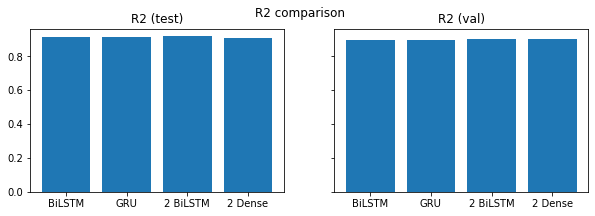

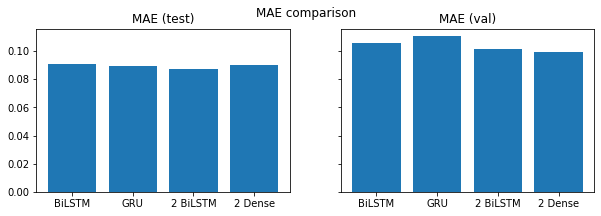

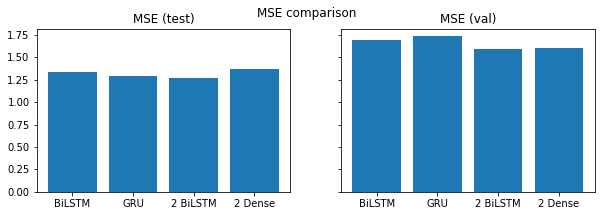

In [41]:
fig, plots = pyplot.subplots(1, 2, sharey = True, figsize=(10, 3))
fig.suptitle('R2 comparison')
plots[0].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [r2_bilstm, r2_gru, r2_2bilstm, r2_bilstm_2dense])
plots[0].set_title("R2 (test)")
plots[1].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [r2_bilstm_val, r2_gru_val, r2_2bilstm_val, r2_bilstm_2dense_val])
plots[1].set_title("R2 (val)")
pyplot.show()

fig, plots = pyplot.subplots(1, 2, sharey = True, figsize=(10, 3))
fig.suptitle('MAE comparison')
plots[0].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [mae_bilstm, mae_gru, mae_2bilstm, mae_bilstm_2dense])
plots[0].set_title("MAE (test)")
plots[1].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [mae_bilstm_val, mae_gru_val, mae_2bilstm_val, mae_bilstm_2dense_val])
plots[1].set_title("MAE (val)")
pyplot.show()

fig, plots = pyplot.subplots(1, 2, sharey = True, figsize=(10, 3))
fig.suptitle('MSE comparison')
plots[0].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [mse_bilstm, mse_gru, mse_2bilstm, mse_bilstm_2dense])
plots[0].set_title("MSE (test)")
plots[1].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [mse_bilstm_val, mse_gru_val, mse_2bilstm_val, mse_bilstm_2dense_val])
plots[1].set_title("MSE (val)")
pyplot.show()

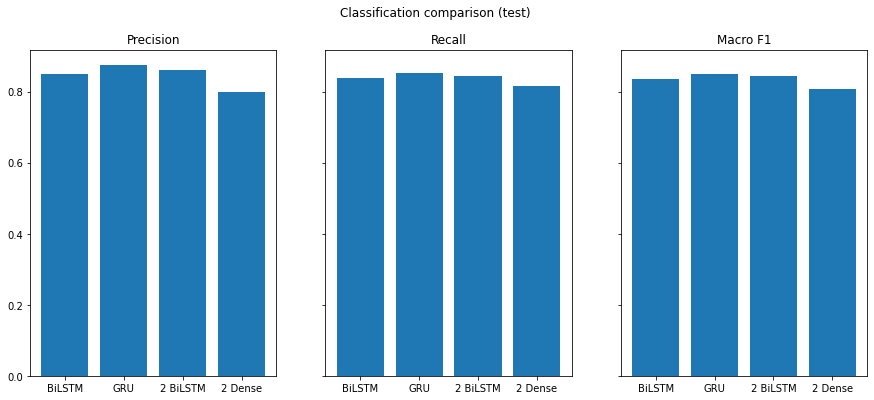

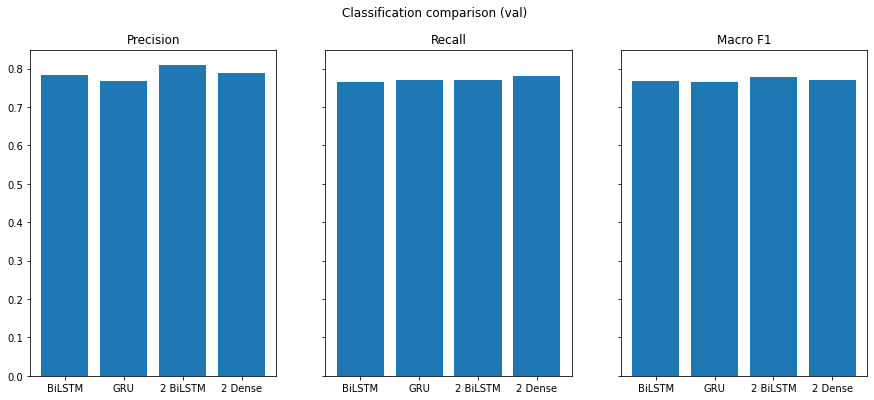

In [42]:
#Test set
prfs_bilstm = precision_recall_fscore_support(true_no_punct_idx, predBiLSTM_no_punct_idx, average="macro",zero_division=0)
prfs_gru = precision_recall_fscore_support(true_no_punct_idx, predGRU_no_punct_idx, average="macro",zero_division=0)
prfs_2bilstm = precision_recall_fscore_support(true_no_punct_idx, predBiLSTM2_no_punct_idx, average="macro",zero_division=0)
prfs_2dense = precision_recall_fscore_support(true_no_punct_idx, predBiLSTM_2dense_no_punct_idx, average="macro",zero_division=0)
#Validation set
prfs_bilstm_val = precision_recall_fscore_support(true_no_punct_val_idx, predBiLSTM_no_punct_val_idx, average="macro",zero_division=0)
prfs_gru_val = precision_recall_fscore_support(true_no_punct_val_idx, predGRU_no_punct_val_idx, average="macro",zero_division=0)
prfs_2bilstm_val = precision_recall_fscore_support(true_no_punct_val_idx, predBiLSTM2_no_punct_val_idx, average="macro",zero_division=0)
prfs_2dense_val = precision_recall_fscore_support(true_no_punct_val_idx, predBiLSTM_2dense_no_punct_val_idx, average="macro",zero_division=0)

fig, plots = pyplot.subplots(1,3, sharey=True, figsize=(15, 6))
fig.suptitle('Classification comparison (test)')
plots[0].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [prfs_bilstm[0], prfs_gru[0], prfs_2bilstm[0], prfs_2dense[0]])
plots[0].set_title("Precision")
plots[1].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [prfs_bilstm[1], prfs_gru[1], prfs_2bilstm[1], prfs_2dense[1]])
plots[1].set_title("Recall")
plots[2].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [prfs_bilstm[2], prfs_gru[2], prfs_2bilstm[2], prfs_2dense[2]])
plots[2].set_title("Macro F1")

pyplot.show()


fig, plots = pyplot.subplots(1,3, sharey=True, figsize=(15, 6))
fig.suptitle('Classification comparison (val)')
plots[0].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [prfs_bilstm_val[0], prfs_gru_val[0], prfs_2bilstm_val[0], prfs_2dense_val[0]])
plots[0].set_title("Precision")
plots[1].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [prfs_bilstm_val[1], prfs_gru_val[1], prfs_2bilstm_val[1], prfs_2dense_val[1]])
plots[1].set_title("Recall")
plots[2].bar(['BiLSTM','GRU','2 BiLSTM', '2 Dense'], [prfs_bilstm_val[2], prfs_gru_val[2], prfs_2bilstm_val[2], prfs_2dense_val[2]])
plots[2].set_title("Macro F1")

pyplot.show()

In [43]:
def fill_no_tags(score_array, score_idx):
    
    full = len(voc) * [-.01]

    for i in range(len(score_idx)):
        full[score_idx[i]] = score_array[i]
    return np.array(full)
    

# TODO: Mettere i tag al posto dei numeri nei grafici qui sotto

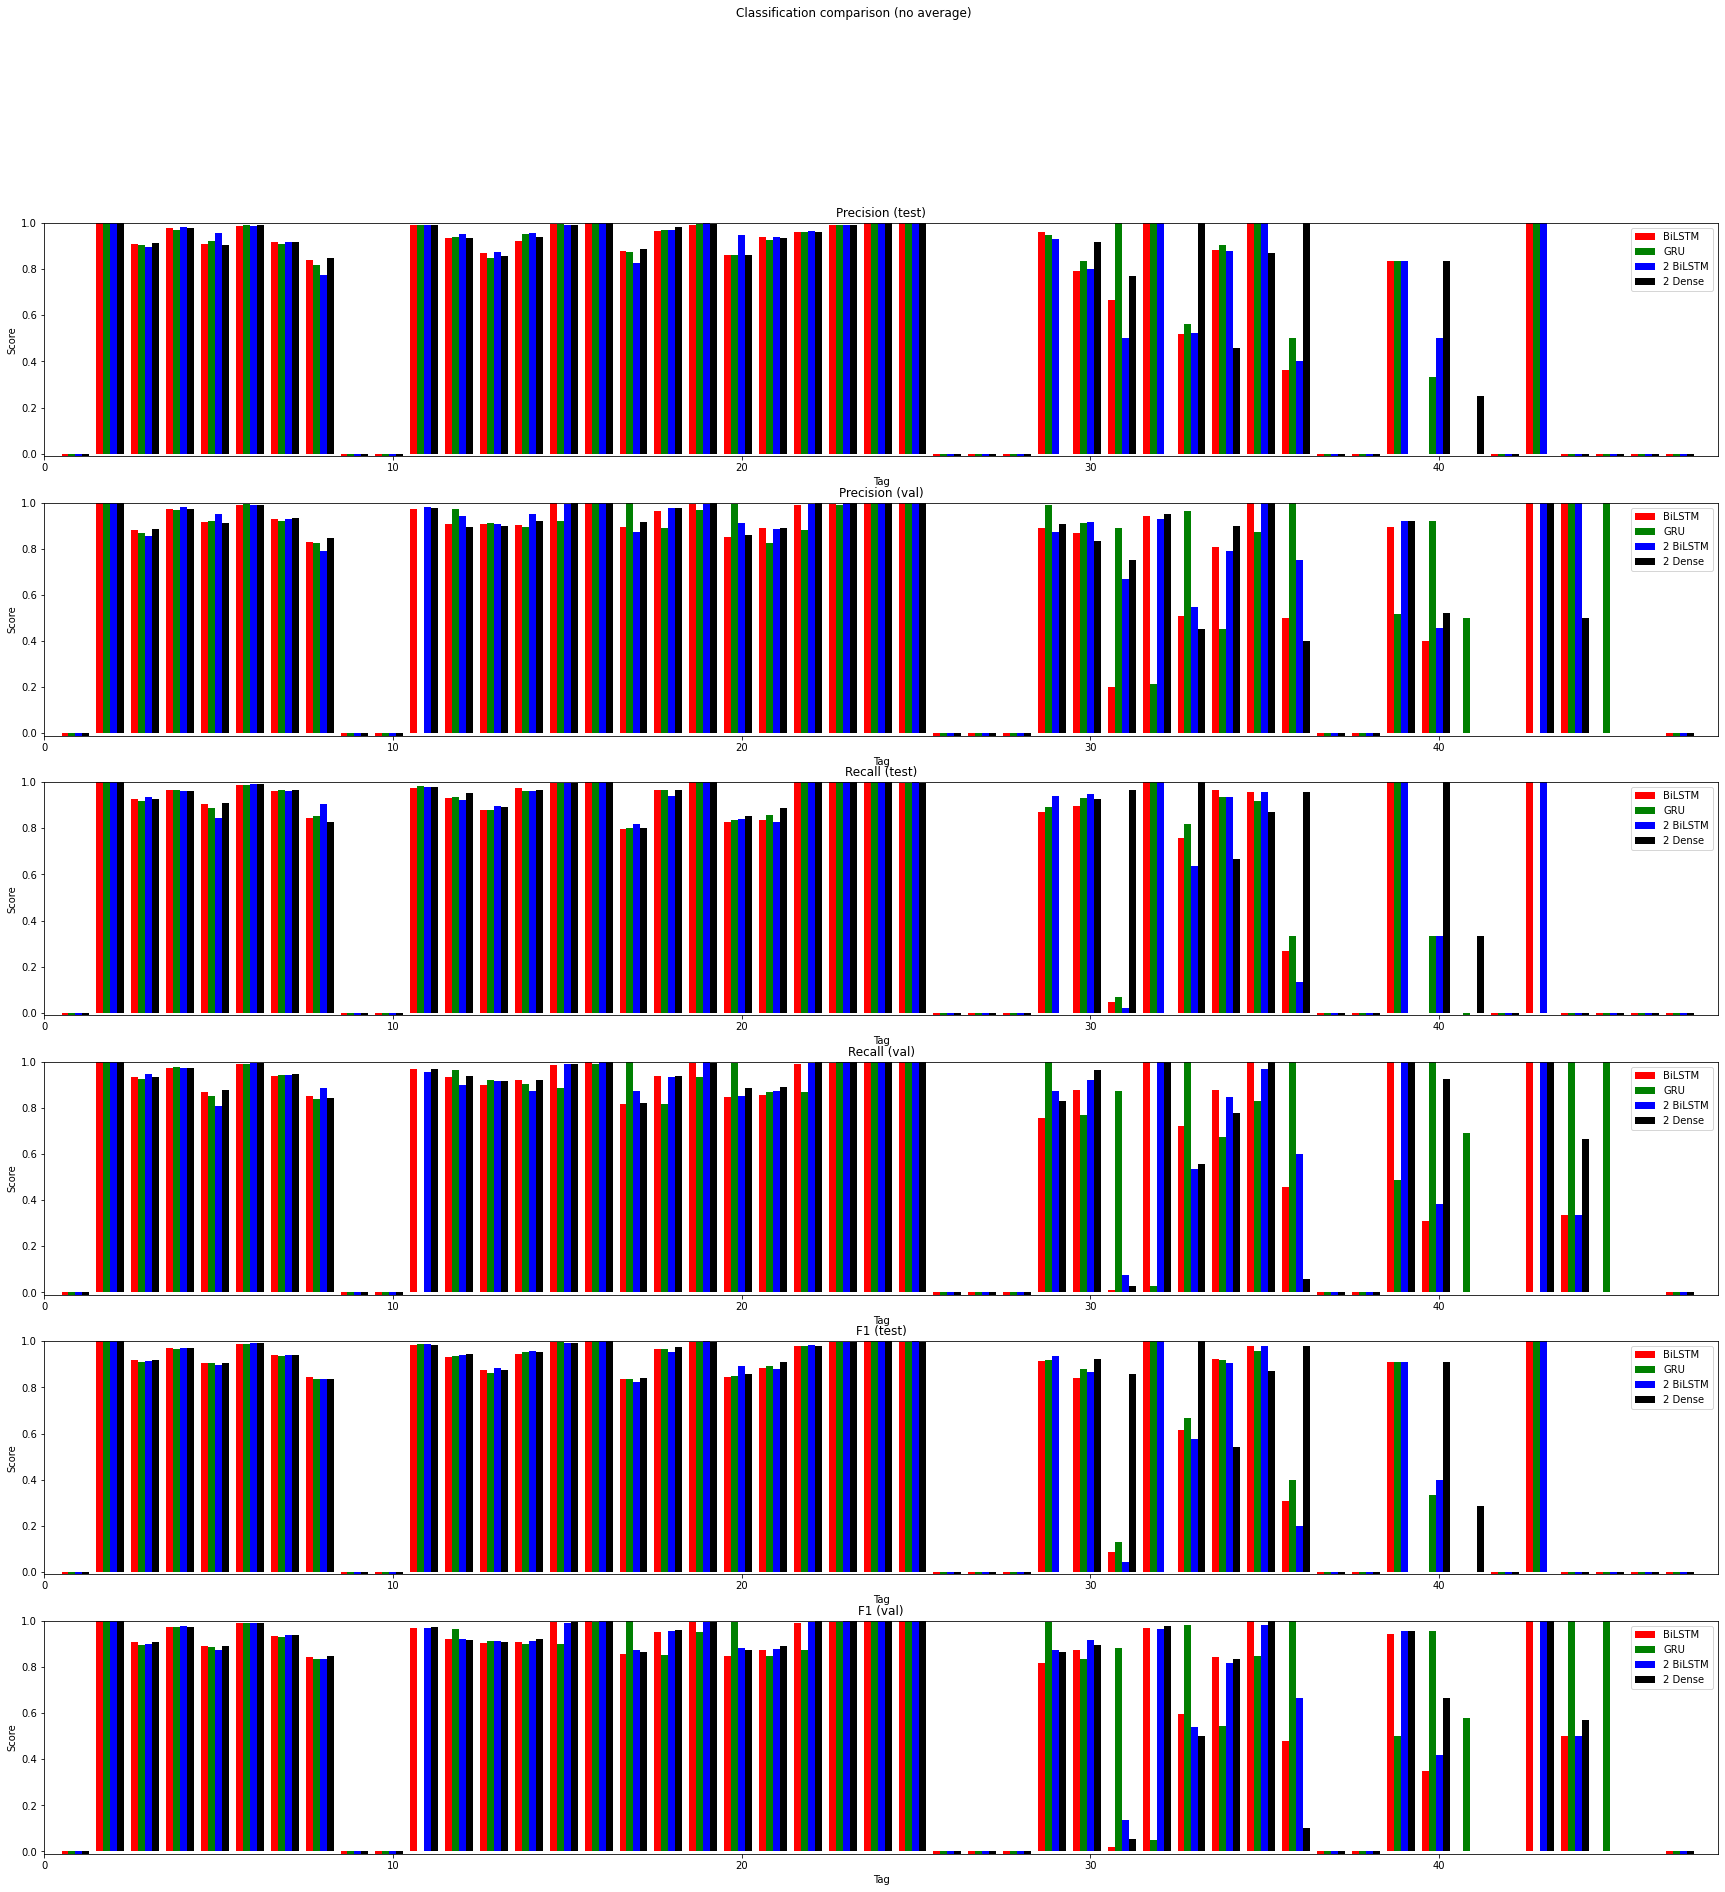

In [44]:
#We can go down at the level of a single class to inspect in more detail if some models are able to detect some classes better than others.
prfs_bilstm = list(precision_recall_fscore_support(true_no_punct_idx, predBiLSTM_no_punct_idx, average=None,zero_division=0))
prfs_bilstm_val = list(precision_recall_fscore_support(true_no_punct_val_idx, predBiLSTM_no_punct_val_idx, average=None,zero_division=0))

prfs_gru = list(precision_recall_fscore_support(true_no_punct_idx, predGRU_no_punct_idx, average=None,zero_division=0))
prfs_gru_val = list(precision_recall_fscore_support(true_no_punct_val_idx, predGRU_no_punct_val_idx, average=None,zero_division=0))

prfs_2bilstm = list(precision_recall_fscore_support(true_no_punct_idx, predBiLSTM2_no_punct_idx, average=None,zero_division=0))
prfs_2bilstm_val = list(precision_recall_fscore_support(true_no_punct_val_idx, predBiLSTM2_no_punct_val_idx, average=None,zero_division=0))

prfs_2dense = list(precision_recall_fscore_support(true_no_punct_idx, predBiLSTM_2dense_no_punct_idx, average=None,zero_division=0))
prfs_2dense_val = list(precision_recall_fscore_support(true_no_punct_val_idx, predBiLSTM_2dense_no_punct_val_idx, average=None,zero_division=0))

#From the previous plots we can see that some models detect more tags than others (for example the ":" symbol). This makes the comparison more difficult. The following call puts every measurement at the same level.
#Precision
prfs_bilstm[0] = fill_no_tags(prfs_bilstm[0], np.unique(true_no_punct_idx))
prfs_bilstm_val[0] = fill_no_tags(prfs_bilstm_val[0], np.unique(true_no_punct_val_idx))

prfs_gru[0] = fill_no_tags(prfs_gru[0], np.unique(true_no_punct_idx))
prfs_gru_val[0] = fill_no_tags(prfs_gru_val[0], np.unique(true_no_punct_val_idx))

prfs_2bilstm[0] = fill_no_tags(prfs_2bilstm[0], np.unique(true_no_punct_idx))
prfs_2bilstm_val[0] = fill_no_tags(prfs_2bilstm_val[0], np.unique(true_no_punct_val_idx))

prfs_2dense[0] = fill_no_tags(prfs_2dense[0], np.unique(true_no_punct_idx))
prfs_2dense_val[0] = fill_no_tags(prfs_2dense_val[0], np.unique(true_no_punct_val_idx))


#Recall
prfs_bilstm[1] = fill_no_tags(prfs_bilstm[1], np.unique(true_no_punct_idx))
prfs_bilstm_val[1] = fill_no_tags(prfs_bilstm_val[1], np.unique(true_no_punct_val_idx))

prfs_gru[1] = fill_no_tags(prfs_gru[1], np.unique(predGRU_no_punct_idx))
prfs_gru_val[1] = fill_no_tags(prfs_gru_val[1], np.unique(true_no_punct_val_idx))

prfs_2bilstm[1] = fill_no_tags(prfs_2bilstm[1], np.unique(true_no_punct_idx))
prfs_2bilstm_val[1] = fill_no_tags(prfs_2bilstm_val[1], np.unique(true_no_punct_val_idx))

prfs_2dense[1] = fill_no_tags(prfs_2dense[1], np.unique(true_no_punct_idx))
prfs_2dense_val[1] = fill_no_tags(prfs_2dense_val[1], np.unique(true_no_punct_val_idx))


#F1
prfs_bilstm[2] = fill_no_tags(prfs_bilstm[2], np.unique(true_no_punct_idx))
prfs_bilstm_val[2] = fill_no_tags(prfs_bilstm_val[2], np.unique(true_no_punct_val_idx))

prfs_gru[2] = fill_no_tags(prfs_gru[2], np.unique(true_no_punct_idx))
prfs_gru_val[2] = fill_no_tags(prfs_gru_val[2], np.unique(true_no_punct_val_idx))

prfs_2bilstm[2] = fill_no_tags(prfs_2bilstm[2], np.unique(true_no_punct_idx))
prfs_2bilstm_val[2] = fill_no_tags(prfs_2bilstm_val[2], np.unique(true_no_punct_val_idx))

prfs_2dense[2] = fill_no_tags(prfs_2dense[2], np.unique(true_no_punct_idx))
prfs_2dense_val[2] = fill_no_tags(prfs_2dense_val[2], np.unique(true_no_punct_val_idx))


fig, plots = pyplot.subplots(6,1, sharey=True, figsize=(30,30))
fig.suptitle('Classification comparison (no average)')

#by construction, the width must satisfy 4*width < 1 otherwise more bars will overlap.
width=.2
labels_axis = np.arange(1, len(voc) + 1 )

#Precision
#Test set
plots[0].bar(labels_axis-2*width, prfs_bilstm[0], width, label="BiLSTM", color='red')
plots[0].bar(labels_axis-width, prfs_gru[0], width, label="GRU", color='green')
plots[0].bar(labels_axis, prfs_2bilstm[0], width, label="2 BiLSTM", color='blue')
plots[0].bar(labels_axis+width, prfs_2dense[0], width, label="2 Dense", color='black')
plots[0].set_title('Precision (test)')

plots[0].set_ylim([-.01,1])
plots[0].set_xlim([0,len(voc)+1])
plots[0].set_xlabel('Tag')
plots[0].set_ylabel('Score')
plots[0].legend(loc='upper right')

#Validation set
plots[1].bar(labels_axis-2*width, prfs_bilstm_val[0], width, label="BiLSTM", color='red')
plots[1].bar(labels_axis-width, prfs_gru_val[0], width, label="GRU", color='green')
plots[1].bar(labels_axis, prfs_2bilstm_val[0], width, label="2 BiLSTM", color='blue')
plots[1].bar(labels_axis+width, prfs_2dense_val[0], width, label="2 Dense", color='black')
plots[1].set_title('Precision (val)')

plots[1].set_ylim([-.01,1])
plots[1].set_xlim([0,len(voc)+1])
plots[1].set_xlabel('Tag')
plots[1].set_ylabel('Score')
plots[1].legend(loc='upper right')


#Recall
#Test set
plots[2].bar(labels_axis-2*width, prfs_bilstm[1], width, label="BiLSTM", color='red')
plots[2].bar(labels_axis-width, prfs_gru[1], width, label="GRU", color='green')
plots[2].bar(labels_axis, prfs_2bilstm[1], width, label="2 BiLSTM", color='blue')
plots[2].bar(labels_axis+width, prfs_2dense[1], width, label="2 Dense", color='black')
plots[2].set_title('Recall (test)')

plots[2].set_ylim([-.01,1])
plots[2].set_xlim([0,len(voc)+1])
plots[2].set_xlabel('Tag')
plots[2].set_ylabel('Score')
plots[2].legend(loc='upper right')

#Validation set
plots[3].bar(labels_axis-2*width, prfs_bilstm_val[1], width, label="BiLSTM", color='red')
plots[3].bar(labels_axis-width, prfs_gru_val[1], width, label="GRU", color='green')
plots[3].bar(labels_axis, prfs_2bilstm_val[1], width, label="2 BiLSTM", color='blue')
plots[3].bar(labels_axis+width, prfs_2dense_val[1], width, label="2 Dense", color='black')
plots[3].set_title('Recall (val)')

plots[3].set_ylim([-.01,1])
plots[3].set_xlim([0,len(voc)+1])
plots[3].set_xlabel('Tag')
plots[3].set_ylabel('Score')
plots[3].legend(loc='upper right')

#F1
#Test set
plots[4].bar(labels_axis-2*width, prfs_bilstm[2], width, label="BiLSTM", color='red')
plots[4].bar(labels_axis-width, prfs_gru[2], width, label="GRU", color='green')
plots[4].bar(labels_axis, prfs_2bilstm[2], width, label="2 BiLSTM", color='blue')
plots[4].bar(labels_axis+width, prfs_2dense[2], width, label="2 Dense", color='black')
plots[4].set_title('F1 (test)')

plots[4].set_ylim([-.01,1])
plots[4].set_xlim([0,len(voc)+1])
plots[4].set_xlabel('Tag')
plots[4].set_ylabel('Score')
plots[4].legend(loc='upper right')

#Validation set
plots[5].bar(labels_axis-2*width, prfs_bilstm_val[2], width, label="BiLSTM", color='red')
plots[5].bar(labels_axis-width, prfs_gru_val[2], width, label="GRU", color='green')
plots[5].bar(labels_axis, prfs_2bilstm_val[2], width, label="2 BiLSTM", color='blue')
plots[5].bar(labels_axis+width, prfs_2dense_val[2], width, label="2 Dense", color='black')
plots[5].set_title('F1 (val)')

plots[5].set_ylim([-.01,1])
plots[5].set_xlim([0,len(voc)+1])
plots[5].set_xlabel('Tag')
plots[5].set_ylabel('Score')
plots[5].legend(loc='upper right')

pyplot.show()

## Error analysis

### From the metrics, we can see that the results obtained in the validation set are coherent with the results on the test set. By "coherent", we mean that:
- Whenever a score (e.g. F1 score) is high for a single tag in the test set, the same holds for the same tag in the validation set (when the supports of the given tag are sufficiently close in both sets). This can be easily confirmed by looking at the classification reports.
- The classification capabilities of the models are very similar: we can quickly judge it by comparing the graphical representations of the confusion matrices generated from the performances of the models in the test set and in the validation set (whenever the supports of the given tag as sufficiently close in both sets, which can be seen again in the classification reports).
- The R2 is very close to 1 in both the validation and test sets.

### Since the results are coherent, we can inspect the results obtained in the test set. We can observe in many ways that a lot of classes are correctly recognized most of the time. We want to inspect and hopefully give an explanation as for why some classes are not.

In [110]:
def sort_by_prop(class_rep_dict, prop):
  #The last 3 items are aggregated properties that we don't care about
  rep_prop_sorted = list(class_rep_dict.items())[:-3]
  #I sort them by increasing prop
  rep_prop_sorted.sort(key=lambda x: (-x[1][prop], x[0]), reverse=True)
  return rep_prop_sorted

In [114]:
#best n_tags and worst n_tags
n_tags = 10
lenf = 200

#I sort the elements by decreasing f1 score.
#And finally I select the first n_tags and the last n_tags
BiLSTM_f1_sorted = sort_by_prop(crep_BiLSTM2_dict, 'f1-score')
GRU_f1_sorted = sort_by_prop(crep_GRU_dict, 'f1-score')
BiLSTM2_f1_sorted = sort_by_prop(crep_BiLSTM2_dict, 'f1-score')
BiLSTM_2dense_f1_sorted = sort_by_prop(crep_BiLSTM_2dense_dict, 'f1-score')

print('Worst and best classified tags for the model with a Bidirectional LSTM Layer')
print('Worst:\t',[(tag, '{:.3f}'.format(metrics['f1-score'])) for tag,metrics in BiLSTM_f1_sorted[:n_tags]])
print('Best:\t',[(tag, '{:.3f}'.format(metrics['f1-score'])) for tag,metrics in BiLSTM_f1_sorted[:-n_tags:-1]])
print(lenf*'-')

print('Worst and best classified tags for the model with a GRU Layer')
print('Worst:\t',[(tag, '{:.3f}'.format(metrics['f1-score'])) for tag,metrics in GRU_f1_sorted[:n_tags]])
print('Best:\t',[(tag, '{:.3f}'.format(metrics['f1-score'])) for tag,metrics in GRU_f1_sorted[:-n_tags:-1]])
print(lenf*'-')

print('Worst and best classified tags for the model with two Bidirectional LSTM Layers')
print('Worst:\t',[(tag, '{:.3f}'.format(metrics['f1-score'])) for tag,metrics in BiLSTM2_f1_sorted[:n_tags]])
print('Best:\t',[(tag, '{:.3f}'.format(metrics['f1-score'])) for tag,metrics in BiLSTM2_f1_sorted[:-n_tags:-1]])
print(lenf*'-')

print('Worst and best classified tags for the model with two Dense Layers')
print('Worst:\t',[(tag, '{:.3f}'.format(metrics['f1-score'])) for tag,metrics in BiLSTM_2dense_f1_sorted[:n_tags]])
print('Best:\t',[(tag, '{:.3f}'.format(metrics['f1-score'])) for tag,metrics in BiLSTM_2dense_f1_sorted[:-n_tags:-1]])
print(lenf*'=')

Worst and best classified tags for the model with a Bidirectional LSTM Layer
Worst:	 [('PDT', '0.000'), ('NNPS', '0.043'), ('RBR', '0.200'), ('RBS', '0.400'), ('RP', '0.575'), ('VBN', '0.824'), ('JJ', '0.834'), ('JJR', '0.868'), ('VBP', '0.881'), ('RB', '0.886')]
Best:	 [('', '1.000'), ('$', '1.000'), ('PRP', '1.000'), ('PRP$', '1.000'), ('TO', '1.000'), ('WP', '1.000'), ('WP$', '1.000'), ('POS', '0.997'), ('CC', '0.995')]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Worst and best classified tags for the model with a GRU Layer
Worst:	 [('PDT', '0.000'), ('NNPS', '0.128'), ('RBS', '0.333'), ('RBR', '0.400'), ('RP', '0.667'), ('JJ', '0.835'), ('VBN', '0.838'), ('VBG', '0.849'), ('RB', '0.865'), ('JJR', '0.880')]
Best:	 [('', '1.000'), ('PRP$', '1.000'), ('TO', '1.000'), ('WP', '1.000'), ('WP$', '1.000'), ('$', '0.998'), ('PRP', '0.99

### All models appear to behave very similarly even at the level of the tags. Many tags are classified either badly or well by all the models. Since the models have different architectures behind, it's reasonable to think that the reason lies before the model itself: the training set. We have plotted some histograms about the distribution of the classes. We can use those to look for an explanation as for why some tags are better classified than others. Let's compare for example the distribution of the tag "NNPS" (Proper noun, plural), badly classified by every model, and the tag "PRP\$" (Possessive pronoun).

In [125]:
tag1 = 'NNPS'
tag2 = 'PRP$'

distr_df[(distr_df['tags'] == tag1) | (distr_df['tags'] == tag2)][['tags', 'train_counts']]

,tags,train_counts
21,NNPS,95
26,PRP$,409


### On one hand, it certainly explains why all the models perform better in classifying the "PRP\$" tag rather than the "NNPS" tag, but this doesn't entirely capture the complexity of the situation. A hint is given by the fact that there are other tags with many more "examples" that, however, the model is not able to classify as well as "PRP$". One such example is, trivially, the tag with the maximum number of examples:

In [130]:
distr_df[distr_df['train_counts'] == distr_df['train_counts'].max()][['tags','train_counts']]

,tags,train_counts
19,NN,6270


### NN is the name of the tag used to classify the following: "Noun, singular or mass". This could give another hint as for why this tag requires more effort in order to be recognized correctly, even though there are a lot more examples: there are a lot of possible names, whereas the number of possessive pronouns is very limited. Clearly, other factors may affect the assigned tag to a certain token: after all, the models are very complex and also take into account the tokens around (usually referred to as "context") and their order in both directions. Just to peek at the reason of this apparent discrepancy, rather than considering the total number of examples, we should evaluate the total number of unique examples that can be found both in the training set and in the test set out of the total number unique examples that can be found in the test set. A ratio close to 1 should correlate to good performances, and a small set of possible values should push the ratio towards 1 more easily.

In [170]:
search_tag = 'NN'

words_of_search_tag = []
for index in tqdm.tqdm(df_test.index):
    l_tags = df_test['tags'].iloc[index].split()
    np_tags = np.array(df_test['text'].iloc[index].split())[np.argwhere(np.array(l_tags) == search_tag)]
    words_of_search_tag += np_tags.flatten().tolist()

words_of_search_tag_test = list(set(words_of_search_tag))
print(f'\nNumber of unique words tagged as "{search_tag} in the test set": {len(words_of_search_tag_test)}.')

del words_of_search_tag
words_of_search_tag = []
for index in tqdm.tqdm(df_train.index):
    l_tags = df_train['tags'].iloc[index].split()
    np_tags = np.array(df_train['text'].iloc[index].split())[np.argwhere(np.array(l_tags) == search_tag)]
    words_of_search_tag += np_tags.flatten().tolist()

words_of_search_tag_train = list(set(words_of_search_tag))
print(f'\nNumber of unique words tagged as "{search_tag} in the training set": {len(words_of_search_tag_train)}.')

#Filtering according to the query:
words_of_search_tag_in_train_and_test = [word for word in list(set(words_of_search_tag_train + words_of_search_tag_test)) if word in words_of_search_tag_test and word in words_of_search_tag_train]

print(f'\nNumber of unique words tagged as "{search_tag}" that can be found in both test set and train set: {len(words_of_search_tag_in_train_and_test)}.')
print()
print('Therefore, the ratio we\'re interested in is about about', '{:.2f}.'.format(len(words_of_search_tag_in_train_and_test)/len(words_of_search_tag_test)))

100%|██████████| 652/652 [00:00<00:00, 10284.14it/s]



Number of unique words tagged as "NN in the test set": 818.


100%|██████████| 1963/1963 [00:00<00:00, 11506.74it/s]



Number of unique words tagged as "NN in the training set": 1805.

Number of unique words tagged as "NN" that can be found in both test set and train set: 502.

Therefore, the ratio we're interested in is about about 0.61.


### But since the models are way more complex than that and are not limited to memorizing examples and tagging according to it, we can reasonably expect higher performances.

### We can repeat the exact same procedure for the possessive pronouns:

In [171]:
search_tag = 'PRP$'

words_of_search_tag = []
for index in tqdm.tqdm(df_test.index):
    l_tags = df_test['tags'].iloc[index].split()
    np_tags = np.array(df_test['text'].iloc[index].split())[np.argwhere(np.array(l_tags) == search_tag)]
    words_of_search_tag += np_tags.flatten().tolist()

words_of_search_tag_test = list(set(words_of_search_tag))
print(f'\nNumber of unique words tagged as "{search_tag} in the test set": {len(words_of_search_tag_test)}.')

del words_of_search_tag
words_of_search_tag = []
for index in tqdm.tqdm(df_train.index):
    l_tags = df_train['tags'].iloc[index].split()
    np_tags = np.array(df_train['text'].iloc[index].split())[np.argwhere(np.array(l_tags) == search_tag)]
    words_of_search_tag += np_tags.flatten().tolist()

words_of_search_tag_train = list(set(words_of_search_tag))
print(f'\nNumber of unique words tagged as "{search_tag} in the training set": {len(words_of_search_tag_train)}.')

#Filtering according to the query:
words_of_search_tag_in_train_and_test = [word for word in list(set(words_of_search_tag_train + words_of_search_tag_test)) if word in words_of_search_tag_test and word in words_of_search_tag_train]

print(f'\nNumber of unique words tagged as "{search_tag}" that can be found in both test set and train set: {len(words_of_search_tag_in_train_and_test)}.')
print()
print('Therefore, the ratio we\'re interested in is about about', '{:.2f}.'.format(len(words_of_search_tag_in_train_and_test)/len(words_of_search_tag_test)))

100%|██████████| 652/652 [00:00<00:00, 13857.53it/s]



Number of unique words tagged as "PRP$ in the test set": 8.


100%|██████████| 1963/1963 [00:00<00:00, 15366.22it/s]


Number of unique words tagged as "PRP$ in the training set": 13.

Number of unique words tagged as "PRP$" that can be found in both test set and train set: 8.

Therefore, the ratio we're interested in is about about 1.00.


### Which explains the discrepancy we've observed.

In [ ]:
# print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(xtest_raw_ds), axis=1), digits=4))

### Plot the loss and the F1 score

Old code, remove if not useful

In [ ]:
# fig, axs = plt.subplots(2, figsize=(8, 10))

# x_len = np.arange(1, len(history.history['f1_score'])+ 1)

# axs[0].plot(x_len, history.history['loss'])
# axs[0].plot(x_len, history.history['val_loss'])
# axs[0].set_title('model loss')
# axs[0].set_ylabel('loss')
# axs[0].set_xlabel('epoch')
# axs[0].legend(['train', 'val'], loc='upper left')
# axs[0].set_xticks(x_len)

# axs[1].plot(x_len, history.history['f1_score'])
# axs[1].plot(x_len, history.history['val_f1_score'])
# axs[1].set_title('model f1 score macro avg')
# axs[1].set_ylabel('f1 macro avg')
# axs[1].set_xlabel('epoch')
# axs[1].legend(['train', 'val'], loc='upper left')
# axs[1].set_xticks(x_len)
# axs[1].set_yticks(np.arange(0.35, 0.65, step=0.02))

# fig.show()